In [1]:
import os
import subprocess
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

In [2]:
# os.system(f"openstudio workflow/run_analysis.rb -y project_national/national_baseline.yml -n 1 -k")

In [3]:
building_unit_type_to_resstock_category = {"2": 'Multi-Family with 2 - 4 Units', "3_4": 'Multi-Family with 2 - 4 Units', "5_9": 'Multi-Family with 5+ Units', "10_19": 'Multi-Family with 5+ Units', "20_49": 'Multi-Family with 5+ Units', "50_plus": 'Multi-Family with 5+ Units', "SFA": 'Single-Family Attached', "SFD": 'Single-Family Detached' }
seasons = ['Winter', 'Spring', 'Summer', 'Fall']

In [114]:
for (unit_type, resstock_category) in building_unit_type_to_resstock_category.items():
    print(unit_type)
    # os.system(f"openstudio workflow/run_analysis.rb -y project_minneapolis/minneapolis_upgrades.yml -t {unit_type} -n 1 -k")
    result = subprocess.run(f"openstudio {join('workflow','run_analysis.rb')} -y {join('project_columbus','columbus_upgrades.yml')} -t {unit_type} -n 1 -k", shell=True, capture_output=True, text=True)

    # Print the output and error messages
    print("Output:\n", result.stdout)
    print("Error:\n", result.stderr)
    print("\n")

2
Output:
 YML: project_minneapolis\minneapolis_baseline.yml
Error: Output directory 'minneapolis_baseline_single_2_unit_residence' already exists.

Error:
 


3_4
Output:
 YML: project_minneapolis\minneapolis_baseline.yml
Error: Output directory 'minneapolis_baseline_single_3_4_unit_residence' already exists.

Error:
 


5_9
Output:
 YML: project_minneapolis\minneapolis_baseline.yml
Error: Output directory 'minneapolis_baseline_single_5_9_unit_residence' already exists.

Error:
 


10_19
Output:
 YML: project_minneapolis\minneapolis_baseline.yml
Error: Output directory 'minneapolis_baseline_single_10_19_unit_residence' already exists.

Error:
 


20_49
Output:
 YML: project_minneapolis\minneapolis_baseline.yml
Error: Output directory 'minneapolis_baseline_single_20_49_unit_residence' already exists.

Error:
 


50_plus
Output:
 YML: project_minneapolis\minneapolis_baseline.yml
Error: Output directory 'minneapolis_baseline_single_50_plus_unit_residence' already exists.

Error:
 


SFA


In [4]:
season_to_color = ["blue", "green", "orange", "maroon"]
label_to_column = {"elec": "Fuel Use: Electricity: Total", "temp": "Weather: Drybulb Temperature", "time": "Time"}

In [5]:
def create_graph(graph_type, x_value, y_value, selected_day, median_marker=False):

    # figs, axes = plt.subplots(1,len(building_unit_type_to_resstock_category))
    for i, (unit_type, resstock_category) in enumerate(building_unit_type_to_resstock_category.items()):
        # print(unit_type)
        fig, ax = plt.subplots()
        filepath = join(f"minneapolis_baseline_single_{unit_type}_unit_residence", 'run1','run', 'results_timeseries.csv')
        timeseries_data = pd.read_csv(filepath, low_memory=False, usecols=["Time", "Fuel Use: Electricity: Total", "Weather: Drybulb Temperature"])
        
        # Assuming 'Time' column is of datetime type, if not convert it
        timeseries_data['Time'] = pd.to_datetime(timeseries_data['Time'])

        # Define seasons
        def get_season(date):
            if date.month in [12, 1, 2]:
                return 'Winter'
            elif date.month in [3, 4, 5]:
                return 'Spring'
            elif date.month in [6, 7, 8]:
                return 'Summer'
            else:
                return 'Fall'

        # Create a 'Season' column
        timeseries_data['Season'] = timeseries_data['Time'].apply(get_season)

        # Extract just the date from 'Time'
        timeseries_data['Date'] = timeseries_data['Time'].dt.date

        # Group by 'Date' and 'Season' and calculate the mean temperature for each day
        daily_avg_temp = timeseries_data.groupby(['Date', 'Season'])['Weather: Drybulb Temperature'].mean().reset_index()
        daily_peak_electricity_use = timeseries_data.groupby(['Date', 'Season'])["Fuel Use: Electricity: Total"].max().reset_index()

        # Function to find the representative day for each season
        def find_representative_day(season):
            if selected_day == "median":
                season_data = daily_avg_temp[daily_avg_temp['Season'] == season]
                season_mean_temp = season_data['Weather: Drybulb Temperature'].mean()
                representative_day = season_data.iloc[(season_data['Weather: Drybulb Temperature'] - season_mean_temp).abs().argsort()].iloc[0]
                # print(representative_day['Date'])
                return representative_day['Date']
            if selected_day == "peak_electricity":
                season_data = daily_peak_electricity_use[daily_peak_electricity_use['Season'] == season]
                season_peak_electricity_use = season_data["Fuel Use: Electricity: Total"].max()
                representative_day = season_data[(season_data["Fuel Use: Electricity: Total"] == season_peak_electricity_use)].iloc[0]
                # print(representative_day['Date'])
                return representative_day['Date']

        # Find the representative day for each season
        representative_days = {season: find_representative_day(season) for season in seasons}

        # Filter the original dataframe for the 24-hour periods of the representative days
        representative_days_df = pd.DataFrame()
        for i, (season, representative_day) in enumerate(representative_days.items()):
            # print(representative_day)
            representative_day_data = timeseries_data[(timeseries_data['Date'] == representative_day)]
            # representative_days_df = pd.concat([representative_days_df, representative_day_data])
            # axes[i//2][i % 2].set_title(season)
            if graph_type == "scatter":
                ax.scatter(x=representative_day_data[label_to_column[x_value]], y=representative_day_data[label_to_column[y_value]], c=season_to_color[i], label=season)
            if graph_type == "line":
                ax.plot(representative_day_data[label_to_column[x_value]].dt.hour, representative_day_data[label_to_column[y_value]], linestyle='-', c=season_to_color[i], label=season)
        if median_marker:
            for i, (season, representative_day) in enumerate(representative_days.items()):
                representative_day_data = timeseries_data[(timeseries_data['Date'] == representative_day)]
                ax.annotate('Mean',xy=(ax.get_xlim()[1],representative_day_data[label_to_column[y_value]].mean()), xytext=(ax.get_xlim()[1],representative_day_data[label_to_column[y_value]].mean()), color=season_to_color[i], fontsize=8)
                # ax.axhline(y=representative_day_data[label_to_column[y_value]].mean(), color=season_to_color[i], linestyle='--')
            # axes[i//2][i % 2].scatter(x=representative_day_data["Weather: Drybulb Temperature"], y=representative_day_data["Fuel Use: Electricity: Total"], c=season_to_color[i])
        # print()
        ax.set_title(f"Unit in {unit_type} Unit Residence")
        ax.set_xlabel(label_to_column[x_value])
        ax.set_ylabel(label_to_column[y_value])
        # Shrink current axis by 20%
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.8))
        fig.savefig(join(f"minneapolis_baseline_single_{unit_type}_unit_residence", f"{graph_type}_{selected_day}_{x_value}_{y_value}{'_medmarker' if median_marker else ''}.svg"), bbox_inches='tight')

2
2007-02-01
2007-05-15
2007-08-13
2007-09-07

3_4
2007-02-01
2007-05-15
2007-08-13
2007-09-07

5_9
2007-02-01
2007-05-15
2007-08-13
2007-09-09

10_19
2007-01-09
2007-03-09
2007-08-13
2007-11-17

20_49
2007-12-16
2007-03-04
2007-06-10
2007-11-05

50_plus
2007-02-12
2007-03-04
2007-06-10
2007-11-05

SFA
2007-12-08
2007-03-11
2007-06-16
2007-10-28

SFD
2007-12-13
2007-04-03
2007-07-31
2007-11-20



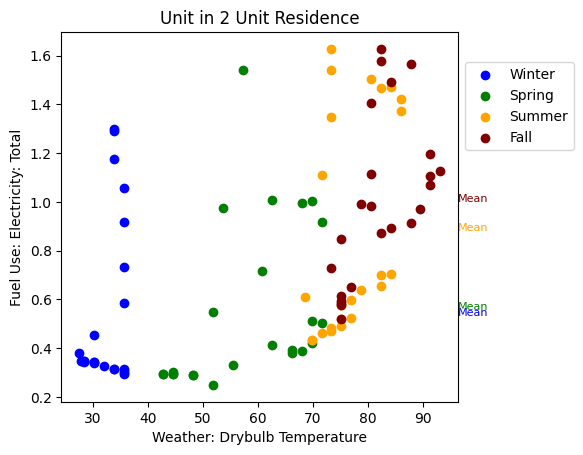

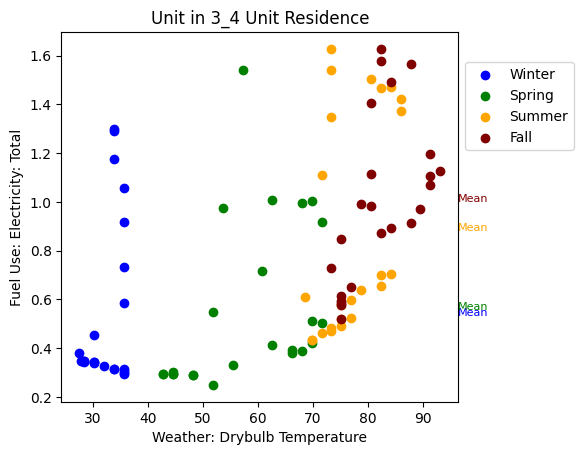

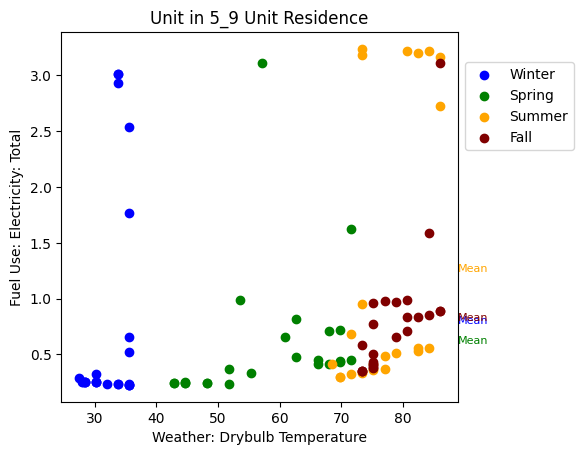

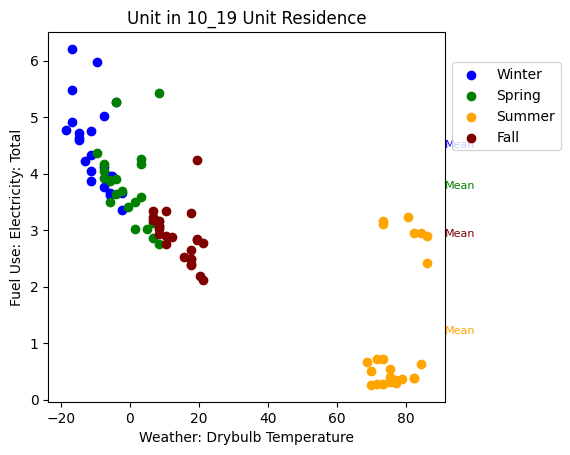

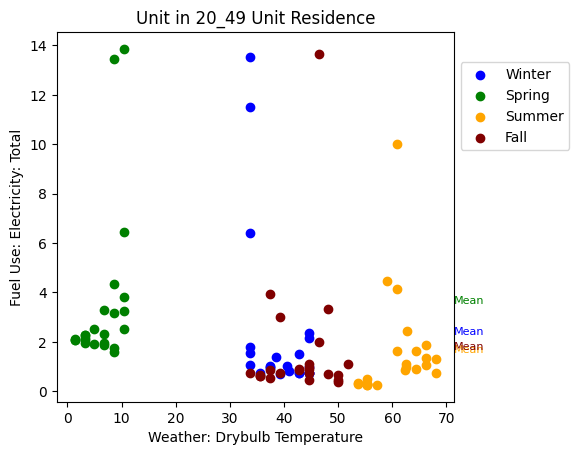

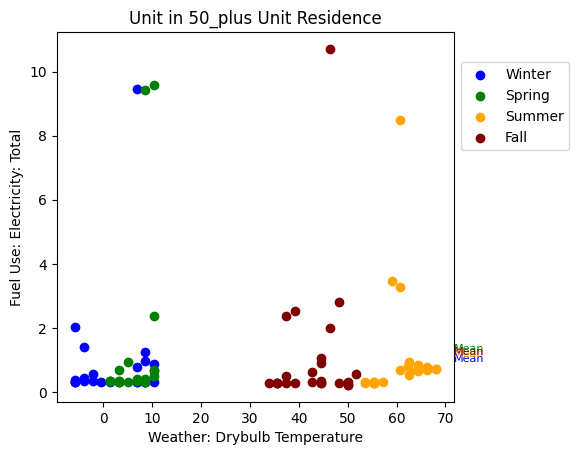

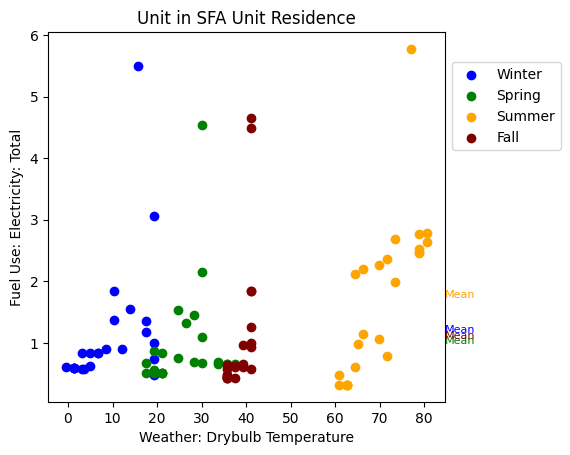

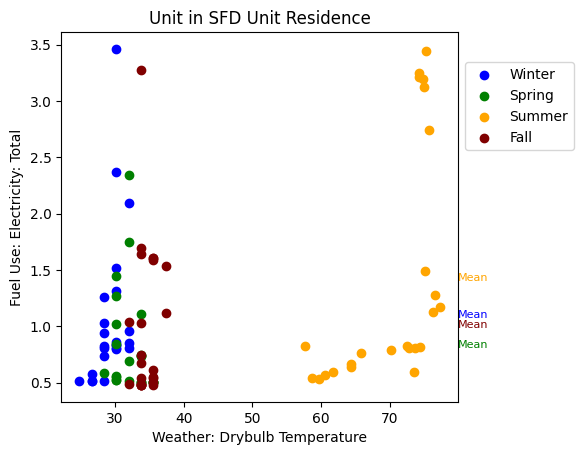

In [286]:
create_graph("scatter", "temp", "elec", "peak_electricity", median_marker=True)

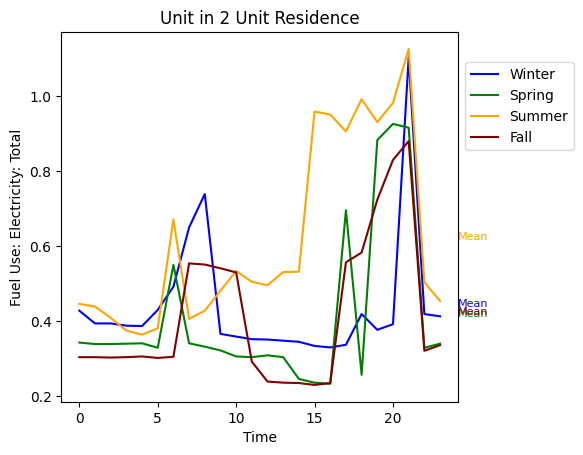

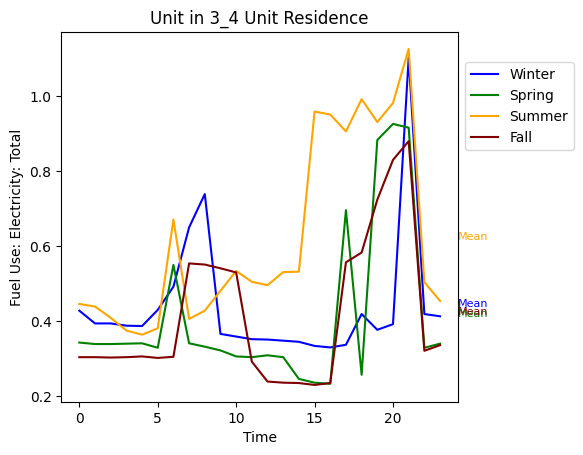

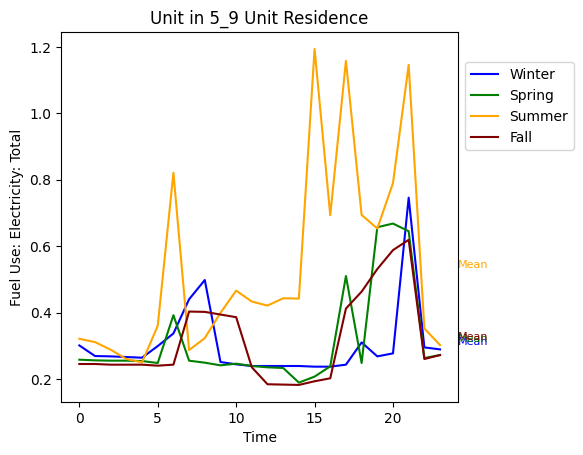

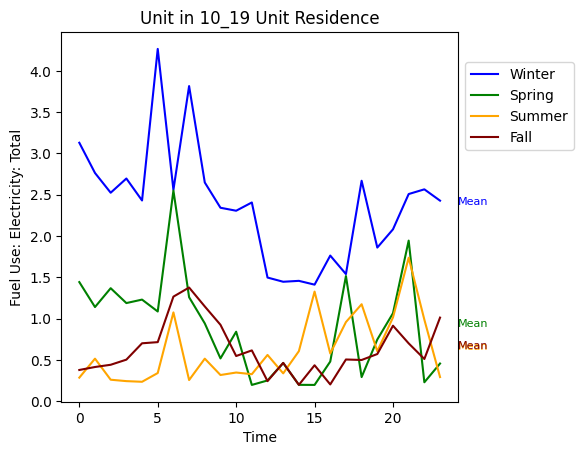

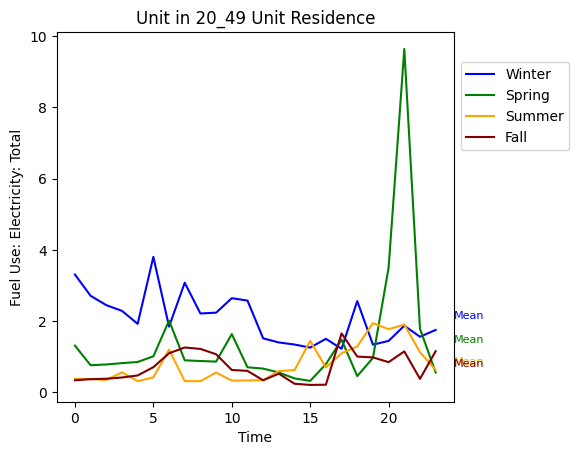

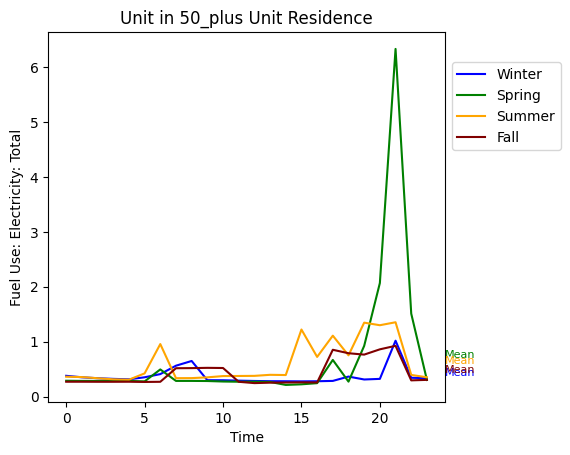

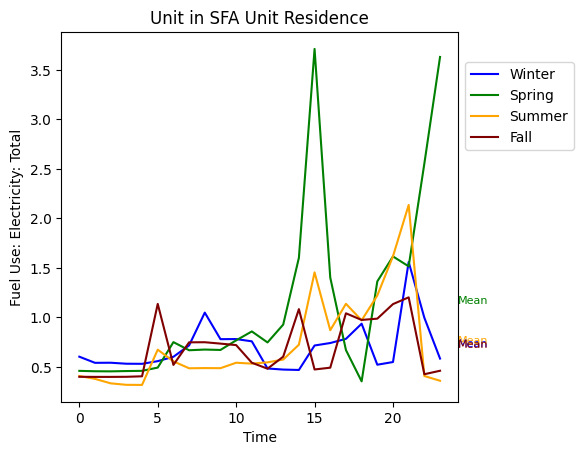

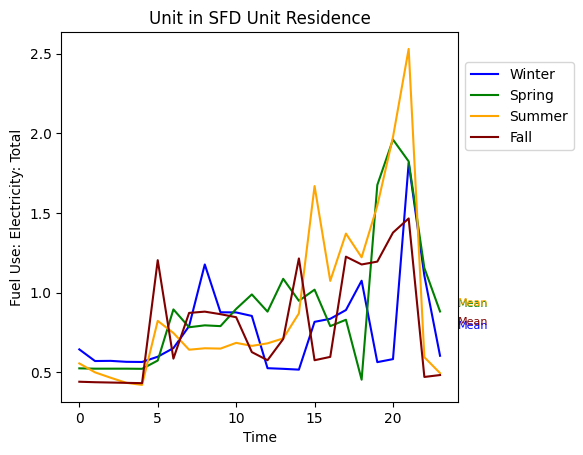

In [159]:
create_graph("line", "time", "elec", "median", median_marker=True)

In [65]:
for (unit_type, resstock_category) in building_unit_type_to_resstock_category.items():
    print(unit_type)
    # os.system(f"openstudio workflow/run_analysis.rb -y project_minneapolis/minneapolis_upgrades.yml -t {unit_type} -n 1 -k")
    result = subprocess.run(f"openstudio {join('workflow','run_analysis.rb')} -y {join('project_minneapolis','minneapolis_upgrades.yml')} -t {unit_type} -n 1 -k", shell=True, capture_output=True, text=True)

    # Print the output and error messages
    print("Output:\n", result.stdout)
    print("Error:\n", result.stderr)
    print("\n")

2
Output:
 YML: project_minneapolis\minneapolis_upgrades.yml
../resources/single_2_unit_buildstock.csv
[Parallel(n_jobs=1)]: 1 / 5 | elapsed:    42.2s
[Parallel(n_jobs=1)]: 2 / 5 | elapsed:   1.5min
[Parallel(n_jobs=1)]: 3 / 5 | elapsed:   2.4min
[Parallel(n_jobs=1)]: 4 / 5 | elapsed:   2.8min
[Parallel(n_jobs=1)]: 5 / 5 | elapsed:   3.7min

Wrote: c:/Users/Arnav/Documents/Research/Trane Technologies/resstock-3.2.0_repo/resstock-3.2.0/minneapolis_upgrades_single_2_unit_residence/results-Baseline.csv
Wrote: c:/Users/Arnav/Documents/Research/Trane Technologies/resstock-3.2.0_repo/resstock-3.2.0/minneapolis_upgrades_single_2_unit_residence/results-ASHP.csv
Wrote: c:/Users/Arnav/Documents/Research/Trane Technologies/resstock-3.2.0_repo/resstock-3.2.0/minneapolis_upgrades_single_2_unit_residence/results-MSHP.csv
Wrote: c:/Users/Arnav/Documents/Research/Trane Technologies/resstock-3.2.0_repo/resstock-3.2.0/minneapolis_upgrades_single_2_unit_residence/results-MSHPwoDucts.csv
Wrote: c:/Users/A

In [85]:
for i, (unit_type, resstock_category) in enumerate(building_unit_type_to_resstock_category.items()):
    for j in range(5):
        filepath = join(f"minneapolis_upgrades_single_{unit_type}_unit_residence", f'run{j+1}','run', 'results_timeseries.csv')
        try:
            timeseries_data = pd.read_csv(filepath, low_memory=False)
            if (timeseries_data.iloc[0]["Time"] is np.NaN):
                timeseries_data = timeseries_data.drop(timeseries_data.index[0])
                timeseries_data.to_csv(filepath)
        except Exception as e:
            pass
        

In [127]:
upgrade_to_color = ["gray", "brown", "pink", "olive", "cyan"]# {"winter": "blue", "spring": , "summer": , "fall": }
upgrade_to_color_dict = {"Baseline": "gray", "ASHP": "brown", "MSHP": "pink", "GSHP": "cyan", "MSHPwoDucts": "olive", "Field Data": "black"}
upgrade_to_shape = ["o", "X", "^", "v", "D"]
upgrade_to_label = ["Baseline", "ASHP", "MSHP", "MSHPwoDucts", "GSHP"]
desired_heating_cols = ["End Use: Electricity: Heating", "End Use: Electricity: Heating Fans/Pumps", "End Use: Electricity: Heating Heat Pump Backup Fans/Pumps"]
desired_cooling_cols = ["End Use: Electricity: Cooling", "End Use: Electricity: Cooling Fans/Pumps"]
desired_hvac_cols = desired_heating_cols + desired_cooling_cols

In [378]:
def create_upgrade_graph(graph_type, x_value, y_value, selected_day="peak_electricity", selected_season=2, median_marker=False, hvac_only=False, break_out_hvac=False, one_representative_day = False):
    # figs, axes = plt.subplots(1,len(building_unit_type_to_resstock_category))
    for i, (unit_type, resstock_category) in enumerate(building_unit_type_to_resstock_category.items()):
        if i != 0:
            continue
        fig, ax = plt.subplots(figsize=(7, 5))
        first_representative_day = None
        for j in range(5):
            filepath = join(f"minneapolis_upgrades_single_{unit_type}_unit_residence", f'run{j+1}','run', 'results_timeseries.csv')
            try:
                timeseries_data = pd.read_csv(filepath, low_memory=False)
                desired_cols = ["Time", "Weather: Drybulb Temperature"]
                if hvac_only:
                    available_heating_cols = [col for col in desired_heating_cols if col in timeseries_data.columns]
                    if len(available_heating_cols) == 0:
                        raise Exception("No heating data available")
                    available_cooling_cols = [col for col in desired_cooling_cols if col in timeseries_data.columns]
                    if len(available_heating_cols) == 0:
                        raise Exception("No cooling data available")
                    available_hvac_cols = available_heating_cols + available_cooling_cols

                    desired_cols += available_hvac_cols
                desired_cols += ["Fuel Use: Electricity: Total"]
                timeseries_data = timeseries_data[desired_cols]
                if hvac_only:
                    if break_out_hvac:
                        timeseries_data["Heating Electricity"] = 0
                        for col in available_heating_cols:
                            if col in timeseries_data.columns:
                                timeseries_data["Heating Electricity"] += timeseries_data[col]
                        timeseries_data["Cooling Electricity"] = 0
                        for col in available_cooling_cols:
                            if col in timeseries_data.columns:
                                timeseries_data["Cooling Electricity"] += timeseries_data[col]
                    else:
                        timeseries_data["HVAC Electricity"] = 0
                        for col in available_hvac_cols:
                            if col in timeseries_data.columns:
                                timeseries_data["HVAC Electricity"] += timeseries_data[col]
                # else:
                #     timeseries_data["Electricity Use (kWh)"] = timeseries_data["Fuel Use: Electricity: Total"]
            except Exception as e:
                continue
            # print(timeseries_data)
            # Assuming 'Time' column is of datetime type, if not convert it
            timeseries_data['Time'] = pd.to_datetime(timeseries_data['Time'])

            # Define seasons
            def get_season(date):
                if date.month in [12, 1, 2]:
                    return 'Winter'
                elif date.month in [3, 4, 5]:
                    return 'Spring'
                elif date.month in [6, 7, 8]:
                    return 'Summer'
                else:
                    return 'Fall'

            # Create a 'Season' column
            timeseries_data['Season'] = timeseries_data['Time'].apply(get_season)

            # Extract just the date from 'Time'
            timeseries_data['Date'] = timeseries_data['Time'].dt.date

            # Group by 'Date' and 'Season' and calculate the mean temperature for each day
            daily_avg_temp = timeseries_data.groupby(['Date', 'Season'])['Weather: Drybulb Temperature'].mean().reset_index()
            daily_peak_electricity_use = timeseries_data.groupby(['Date', 'Season'])["Fuel Use: Electricity: Total"].max().reset_index()

            # Function to find the representative day for each season
            def find_representative_day(season):
                if selected_day == "median":
                    season_data = daily_avg_temp[daily_avg_temp['Season'] == season]
                    season_mean_temp = season_data['Weather: Drybulb Temperature'].mean()
                    representative_day = season_data.iloc[(season_data['Weather: Drybulb Temperature'] - season_mean_temp).abs().argsort()].iloc[0]
                    # print(representative_day['Date'])
                    return representative_day['Date']
                if selected_day == "peak_electricity":
                    season_data = daily_peak_electricity_use[daily_peak_electricity_use['Season'] == season]
                    season_peak_electricity_use = season_data["Fuel Use: Electricity: Total"].max()
                    representative_day = season_data[(season_data["Fuel Use: Electricity: Total"] == season_peak_electricity_use)].iloc[0]
                    # print(representative_day['Date'])
                    return representative_day['Date']

            # Find the representative day for each season
            if one_representative_day and first_representative_day is not None:
                representative_day = first_representative_day
            else:
                representative_day = find_representative_day(seasons[selected_season])
                print(f"Day selected for {unit_type} unit residence is {representative_day}")
            if first_representative_day is None:
                first_representative_day = representative_day
            # representative_days = {season: find_representative_day(season) for season in seasons}
            # print(representative_days)

            # Filter the original dataframe for the 24-hour periods of the representative days
            # representative_days_df = pd.DataFrame()
            # for i, (season, representative_day) in enumerate(representative_days.items()):
            # if season != seasons[selected_season]:
            #     continue
            print(representative_day)
            representative_day_data = timeseries_data[(timeseries_data['Date'] == representative_day)]
            # representative_days_df = pd.concat([representative_days_df, representative_day_data])
            # axes[i//2][i % 2].set_title(season)
            y_column = None
            if hvac_only:
                if break_out_hvac:
                    y_column1 = "Heating Electricity"
                    y_column2 = "Cooling Electricity"
                else:
                    y_column = "HVAC Electricity"
            else:
                y_column = label_to_column[y_value]
            if graph_type == "scatter":
                ax.scatter(x=representative_day_data[label_to_column[x_value]], y=representative_day_data[y_column], c=upgrade_to_color[j], label=upgrade_to_label[j], marker=upgrade_to_shape[j])
            if graph_type == "line":
                ax.plot(representative_day_data[label_to_column[x_value]].dt.hour, representative_day_data[y_column], linestyle='-', c=upgrade_to_color[j], label=upgrade_to_label[j], marker=upgrade_to_shape[j])
                # axes[i//2][i % 2].scatter(x=representative_day_data["Weather: Drybulb Temperature"], y=representative_day_data["Fuel Use: Electricity: Total"], c=upgrade_to_color[j])
            if median_marker:
                # for i, (season, representative_day) in enumerate(representative_days.items()):
                #     if season != seasons[selected_season]:
                #         continue
                #     representative_day_data = timeseries_data[(timeseries_data['Date'] == representative_day)]
                ax.annotate('Mean',xy=(ax.get_xlim()[1],representative_day_data[y_column].mean()), xytext=(ax.get_xlim()[1],representative_day_data[y_column].mean()), color=upgrade_to_color[j], fontsize=8)
            ax.set_title(f"Unit in {unit_type} Unit Residence")
            ax.set_xlabel(label_to_column[x_value])
            ax.set_ylabel(y_column)
            # Shrink current axis by 20%
            # box = ax.get_position()
            # ax.set_position([box.x0, box.y0, box.width, box.height])
            

            # Put a legend to the right of the current axis
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.8))
        fig.savefig(join(f"minneapolis_upgrades_single_{unit_type}_unit_residence", f"{graph_type}{'_one' if one_representative_day else ''}_{selected_day}_{seasons[selected_season].lower()}_{x_value}_{y_value}{'_hvac_only' if hvac_only else ''}{'_medmarker' if median_marker else ''}.svg"), bbox_inches='tight')


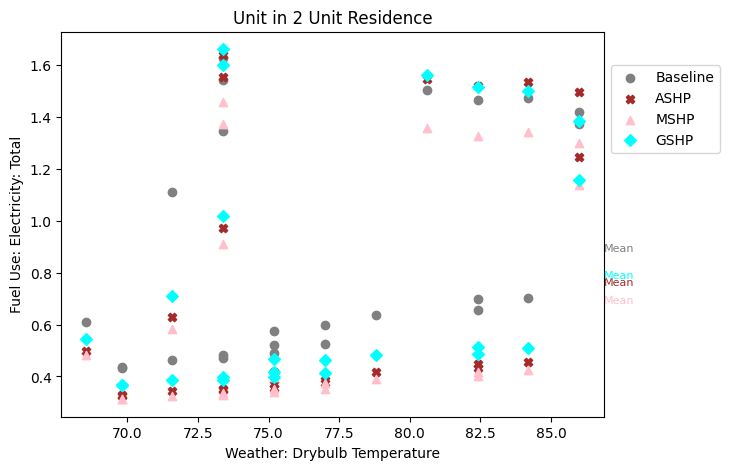

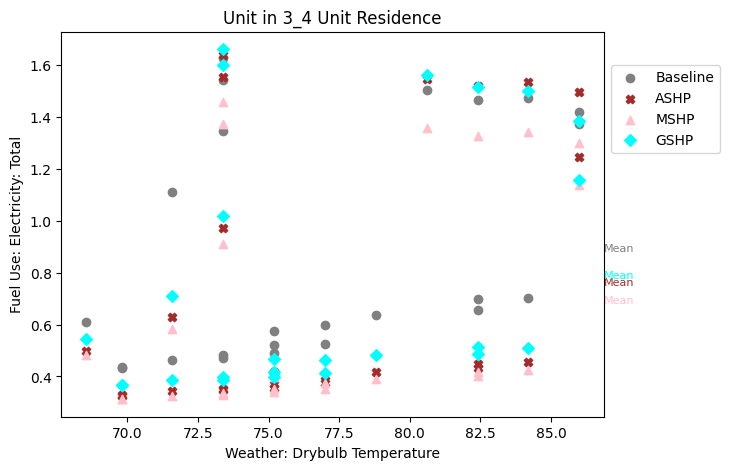

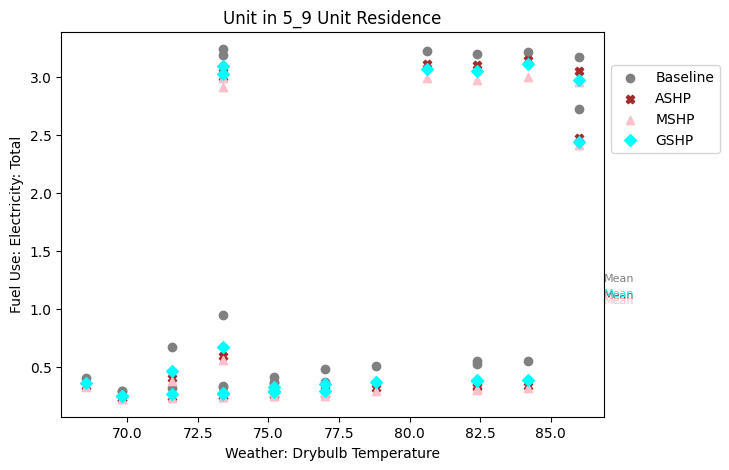

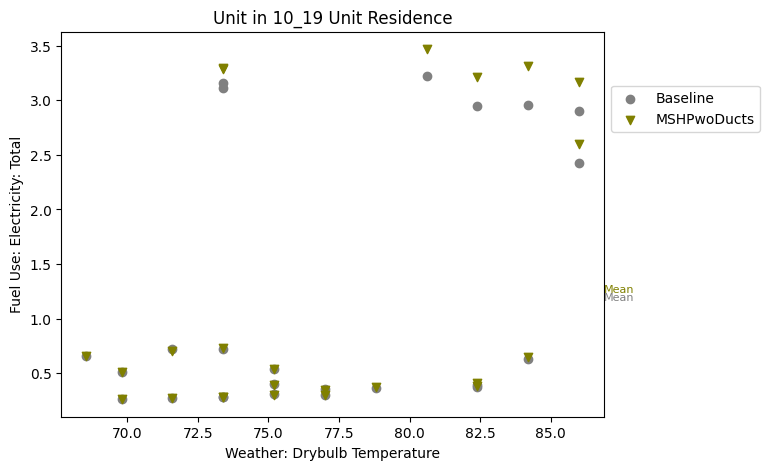

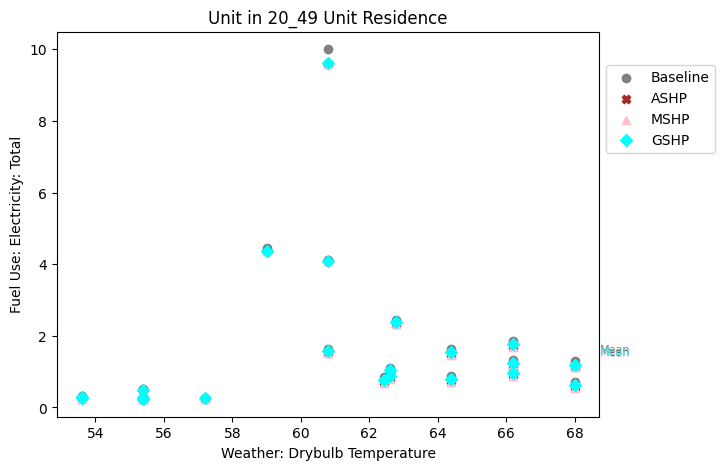

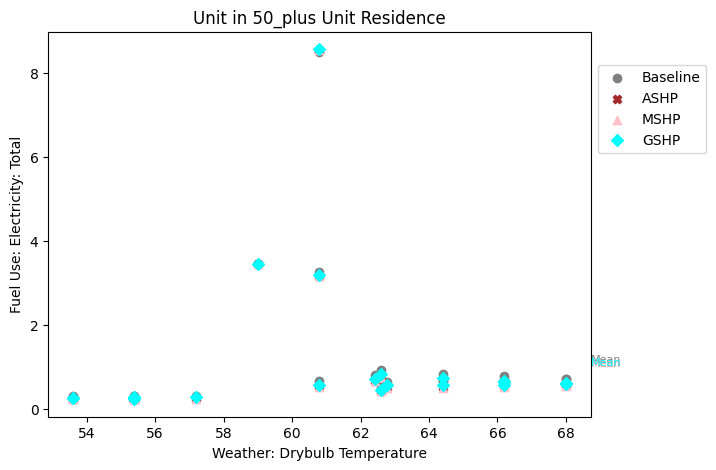

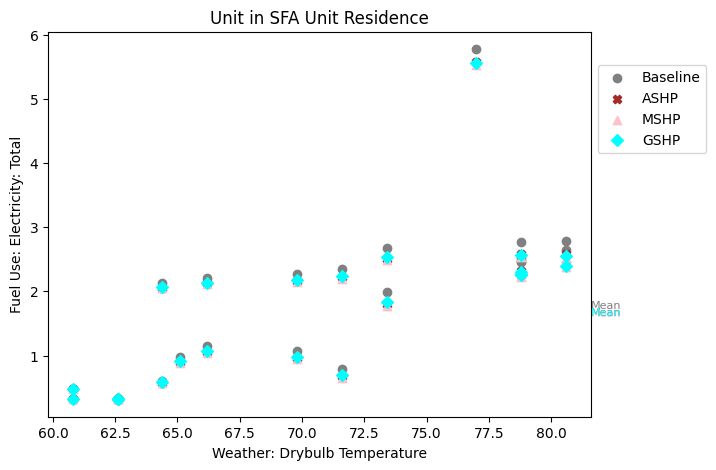

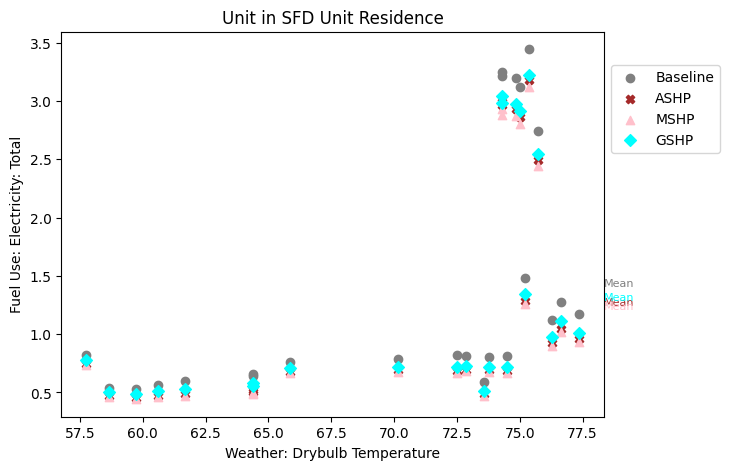

In [261]:
create_upgrade_graph("scatter", "temp", "elec", "peak_electricity", median_marker=True)

Day selected for 2 unit residence is 2007-02-01
2007-02-01
Day selected for 2 unit residence is 2007-12-15
2007-12-15
Day selected for 2 unit residence is 2007-12-15
2007-12-15
Day selected for 2 unit residence is 2007-01-10
2007-01-10


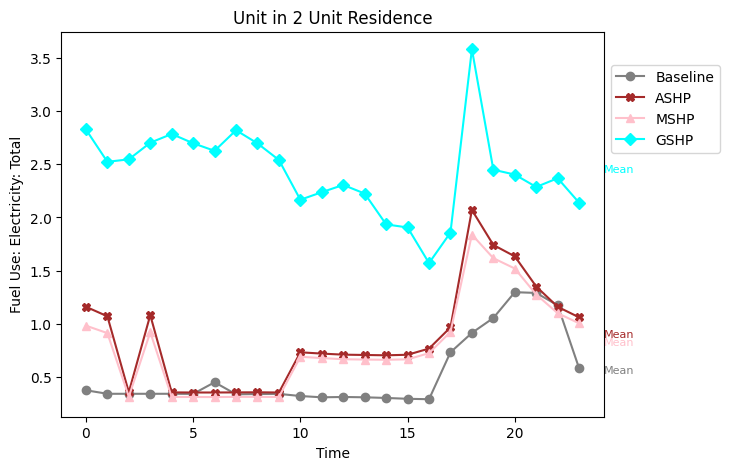

In [387]:
create_upgrade_graph("line", "time", "elec", "peak_electricity", hvac_only=False, selected_season=0, median_marker=True, one_representative_day=False)

In [162]:
unit_type_to_color = ["red", "purple", "teal", "gold", "navy", "magenta", "lime", "black"]

In [174]:
def create_single_color_colormap(base_color, num_shades=10):
    """Create a colormap with shades of a single color."""
    # Convert base color to RGB
    base_rgb = mcolors.to_rgb(base_color)
    
    # Generate shades from black to base color
    colors = [mcolors.to_hex([base_rgb[0] * (i / (num_shades - 1)),
                            base_rgb[1] * (i / (num_shades - 1)),
                            base_rgb[2] * (i / (num_shades - 1))]) for i in range(num_shades)]
    
    # Create colormap
    return colors

 

In [358]:
def compare_residence_types_baseline(graph_type, x_value, y_value, selected_day, selected_season=2, one_representative_day = False):
    # UNCOMMENT FOR A SEASON-SPECIFIC COLOR MAP BASED ON WHICH UNIT IT IS
    # unit_type_to_color = create_single_color_colormap(season_to_color[selected_season])
    fig, ax = plt.subplots()
    first_representative_day = None
    for i, (unit_type, resstock_category) in enumerate(building_unit_type_to_resstock_category.items()):
        filepath = join(f"minneapolis_baseline_single_{unit_type}_unit_residence", 'run1','run', 'results_timeseries.csv')
        timeseries_data = pd.read_csv(filepath, low_memory=False, usecols=["Time", "Fuel Use: Electricity: Total", "Weather: Drybulb Temperature"])
        
        # Assuming 'Time' column is of datetime type, if not convert it
        timeseries_data['Time'] = pd.to_datetime(timeseries_data['Time'])

        # Define seasons
        def get_season(date):
            if date.month in [12, 1, 2]:
                return 'Winter'
            elif date.month in [3, 4, 5]:
                return 'Spring'
            elif date.month in [6, 7, 8]:
                return 'Summer'
            else:
                return 'Fall'

        # Create a 'Season' column
        timeseries_data['Season'] = timeseries_data['Time'].apply(get_season)

        # Extract just the date from 'Time'
        timeseries_data['Date'] = timeseries_data['Time'].dt.date

        # Group by 'Date' and 'Season' and calculate the mean temperature for each day
        daily_avg_temp = timeseries_data.groupby(['Date', 'Season'])['Weather: Drybulb Temperature'].mean().reset_index()
        daily_peak_electricity_use = timeseries_data.groupby(['Date', 'Season'])["Fuel Use: Electricity: Total"].max().reset_index()

        # Function to find the representative day for each season
        def find_representative_day(season):
            if selected_day == "median":
                season_data = daily_avg_temp[daily_avg_temp['Season'] == season]
                season_mean_temp = season_data['Weather: Drybulb Temperature'].mean()
                representative_day = season_data.iloc[(season_data['Weather: Drybulb Temperature'] - season_mean_temp).abs().argsort()].iloc[0]
                # print(representative_day['Date'])
                return representative_day['Date']
            if selected_day == "peak_electricity":
                season_data = daily_peak_electricity_use[daily_peak_electricity_use['Season'] == season]
                season_peak_electricity_use = season_data["Fuel Use: Electricity: Total"].max()
                representative_day = season_data[(season_data["Fuel Use: Electricity: Total"] == season_peak_electricity_use)].iloc[0]
                # print(representative_day['Date'])
                return representative_day['Date']

        # Find the representative day for each season
        if one_representative_day and first_representative_day is not None:
            representative_day = first_representative_day
        else:
            representative_day = find_representative_day(seasons[selected_season])
            print(f"Day selected for {unit_type} unit residence is {representative_day}")
        if first_representative_day is None:
            first_representative_day = representative_day

        # Filter the original dataframe for the 24-hour periods of the representative days
        representative_day_data = timeseries_data[(timeseries_data['Date'] == representative_day)]
        if graph_type == "scatter":
            ax.scatter(x=representative_day_data[label_to_column[x_value]], y=representative_day_data[label_to_column[y_value]], c=unit_type_to_color[i], label=unit_type)
        if graph_type == "line":
            ax.plot(representative_day_data[label_to_column[x_value]].dt.hour, representative_day_data[label_to_column[y_value]], linestyle='-', c=unit_type_to_color[i], label=unit_type)
        if graph_type == "boxplot":
            bp = ax.boxplot(representative_day_data[label_to_column[y_value]], positions=[i], patch_artist=True, boxprops=dict(facecolor=unit_type_to_color[i]), medianprops=dict(linewidth=2, color='orange'), label=unit_type)#, color=unit_type_to_color[i])
            # # Add outline to the median line
            # for median in bp['medians']:
            #     # Median line properties
            #     median.set_color('orange')
            #     median.set_linewidth(2)
                
            #     # Outline properties
            #     ax.plot(median.get_xdata(), median.get_ydata(), color='black', linewidth=4, linestyle='--')
        # if median_marker:
        #     ax.annotate('Mean',xy=(ax.get_xlim()[1],representative_day_data[label_to_column[y_value]].mean()), xytext=(ax.get_xlim()[1],representative_day_data[label_to_column[y_value]].mean()), color=unit_type_to_color[i], fontsize=8)
    ax.set_title(f"{seasons[selected_season]} Baseline for {selected_day.replace('_', ' ').title()} Day")
    if graph_type == "boxplot":
        ax.set_xlabel("Unit in __ Unit Residence")
        ax.set_xticklabels(building_unit_type_to_resstock_category.keys())
        ax.set_ylabel(label_to_column[y_value])
    else:    
        ax.set_xlabel(label_to_column[x_value])
        ax.set_ylabel(label_to_column[y_value])
    
    # Put a legend to the right of the current axis
    if graph_type != "boxplot":
        # Shrink current axis by 20%
        # box = ax.get_position()
        # ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.8))
    fig.savefig(join(f"output", f"{graph_type}{'_one' if one_representative_day else ''}_{selected_day}_{seasons[selected_season].lower()}_{x_value}_{y_value}.svg"), bbox_inches='tight')

Day selected for 2 unit residence is 2007-02-01
Day selected for 3_4 unit residence is 2007-02-01
Day selected for 5_9 unit residence is 2007-02-01
Day selected for 10_19 unit residence is 2007-01-09
Day selected for 20_49 unit residence is 2007-12-16
Day selected for 50_plus unit residence is 2007-02-12
Day selected for SFA unit residence is 2007-12-08
Day selected for SFD unit residence is 2007-12-13


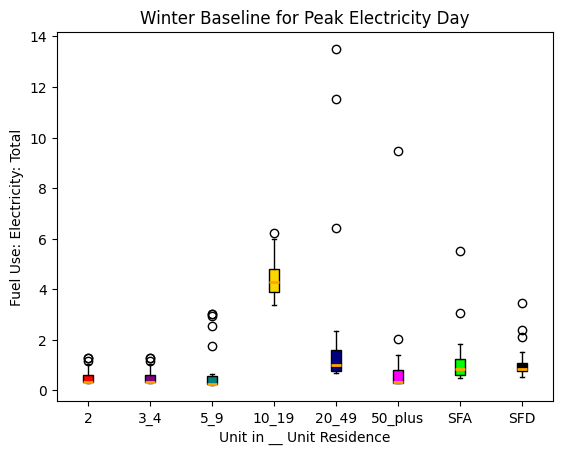

In [359]:
compare_residence_types_baseline("boxplot", "time", "elec", "peak_electricity", selected_season=0, one_representative_day=False)

In [350]:
def compare_residence_types_upgrades(graph_type, x_value, y_value, selected_day, selected_season=2, one_representative_day = False, hvac_only = False, break_out_hvac = False):
    # UNCOMMENT FOR A SEASON-SPECIFIC COLOR MAP BASED ON WHICH UNIT IT IS
    # unit_type_to_color = create_single_color_colormap(season_to_color[selected_season])
    # fig, ax = plt.subplots()
    fig = plt.figure(figsize=(12,6))
    first_representative_day = None
    all_data = pd.DataFrame(columns=["Unit Type", "Upgrade Type", "Electricity Usage"])
    for i, (unit_type, resstock_category) in enumerate(building_unit_type_to_resstock_category.items()):
        for j in range(5):
            filepath = join(f"minneapolis_upgrades_single_{unit_type}_unit_residence", f'run{j+1}','run', 'results_timeseries.csv')
            try:
                timeseries_data = pd.read_csv(filepath, low_memory=False)
                desired_cols = ["Time", "Fuel Use: Electricity: Total", "Weather: Drybulb Temperature"]
                if hvac_only:
                    available_heating_cols = [col for col in desired_heating_cols if col in timeseries_data.columns]
                    if len(available_heating_cols) == 0:
                        raise Exception("No heating data available")
                    available_cooling_cols = [col for col in desired_cooling_cols if col in timeseries_data.columns]
                    if len(available_heating_cols) == 0:
                        raise Exception("No cooling data available")
                    available_hvac_cols = available_heating_cols + available_cooling_cols

                    desired_cols += available_hvac_cols
                timeseries_data = timeseries_data[desired_cols]
                if hvac_only:
                    if break_out_hvac:
                        timeseries_data["Heating Electricity"] = 0
                        for col in available_heating_cols:
                            if col in timeseries_data.columns:
                                timeseries_data["Heating Electricity"] += timeseries_data[col]
                        timeseries_data["Cooling Electricity"] = 0
                        for col in available_cooling_cols:
                            if col in timeseries_data.columns:
                                timeseries_data["Cooling Electricity"] += timeseries_data[col]
                    else:
                        timeseries_data["HVAC Electricity"] = 0
                        for col in available_hvac_cols:
                            if col in timeseries_data.columns:
                                timeseries_data["HVAC Electricity"] += timeseries_data[col]
                # else:
                #     timeseries_data["Electricity Use (kWh)"] = timeseries_data["Fuel Use: Electricity: Total"]
            except Exception as e:
                continue
            # Assuming 'Time' column is of datetime type, if not convert it
            timeseries_data['Time'] = pd.to_datetime(timeseries_data['Time'])

            # Define seasons
            def get_season(date):
                if date.month in [12, 1, 2]:
                    return 'Winter'
                elif date.month in [3, 4, 5]:
                    return 'Spring'
                elif date.month in [6, 7, 8]:
                    return 'Summer'
                else:
                    return 'Fall'

            # Create a 'Season' column
            timeseries_data['Season'] = timeseries_data['Time'].apply(get_season)

            # Extract just the date from 'Time'
            timeseries_data['Date'] = timeseries_data['Time'].dt.date

            # Group by 'Date' and 'Season' and calculate the mean temperature for each day
            daily_avg_temp = timeseries_data.groupby(['Date', 'Season'])['Weather: Drybulb Temperature'].mean().reset_index()
            daily_peak_electricity_use = timeseries_data.groupby(['Date', 'Season'])["Fuel Use: Electricity: Total"].max().reset_index()

            # Function to find the representative day for each season
            def find_representative_day(season):
                if selected_day == "median":
                    season_data = daily_avg_temp[daily_avg_temp['Season'] == season]
                    season_mean_temp = season_data['Weather: Drybulb Temperature'].mean()
                    representative_day = season_data.iloc[(season_data['Weather: Drybulb Temperature'] - season_mean_temp).abs().argsort()].iloc[0]
                    # print(representative_day['Date'])
                    return representative_day['Date']
                if selected_day == "peak_electricity":
                    season_data = daily_peak_electricity_use[daily_peak_electricity_use['Season'] == season]
                    season_peak_electricity_use = season_data["Fuel Use: Electricity: Total"].max()
                    representative_day = season_data[(season_data["Fuel Use: Electricity: Total"] == season_peak_electricity_use)].iloc[0]
                    # print(representative_day['Date'])
                    return representative_day['Date']

            # Find the representative day for each season
            if one_representative_day and first_representative_day is not None:
                representative_day = first_representative_day
            else:
                representative_day = find_representative_day(seasons[selected_season])
                print(f"Day selected for {unit_type} unit residence is {representative_day}")
            if first_representative_day is None:
                first_representative_day = representative_day

            # Filter the original dataframe for the 24-hour periods of the representative days
            representative_day_data = timeseries_data[(timeseries_data['Date'] == representative_day)]
            y_column = None
            if hvac_only:
                if break_out_hvac:
                    y_column1 = "Heating Electricity"
                    y_column2 = "Cooling Electricity"
                else:
                    y_column = "HVAC Electricity"
            else:
                y_column = label_to_column[y_value]
            all_data = pd.concat([all_data, pd.DataFrame({
                "Unit Type": unit_type,
                "Upgrade Type": upgrade_to_label[j],
                "Electricity Usage": representative_day_data[y_column]
            })])
        # if graph_type == "scatter":
        #     ax.scatter(x=representative_day_data[label_to_column[x_value]], y=representative_day_data[y_column], c=unit_type_to_color[i], label=unit_type)
        # if graph_type == "line":
        #     ax.plot(representative_day_data[label_to_column[x_value]].dt.hour, representative_day_data[y_column], linestyle='-', c=unit_type_to_color[i], label=unit_type)
    # print(all_data)
    ax = None
    palette_obj = [upgrade_to_color[upgrade_to_label.index(x)] for x in all_data["Upgrade Type"].unique()]
    print(palette_obj)
    if graph_type == "boxplot":
        ax = sns.boxplot(x="Unit Type", y="Electricity Usage", hue="Upgrade Type", data = all_data, order= building_unit_type_to_resstock_category.keys(), palette = palette_obj)
        print("about to decide box colors")
        for i, artist in enumerate(ax.artists):
            print(f"deciding box color {i}")
            print(f"setting box edge color to {unit_type_to_color[all_data['Unit Type'].unique()[i // 3]]}")
            artist.set_edgecolor(unit_type_to_color[all_data["Unit Type"].unique()[i // 3]])
            artist.set_linewidth(10)  # Adjust the linewidth if needed
            # bp = ax.boxplot(representative_day_data[y_column], positions=[i], patch_artist=True, boxprops=dict(facecolor=unit_type_to_color[i]), medianprops=dict(linewidth=4, color='orange'), label=unit_type)#, color=unit_type_to_color[i])
            # # Add outline to the median line
            # for median in bp['medians']:
            #     # Median line properties
            #     median.set_color('orange')
            #     median.set_linewidth(2)
                
            #     # Outline properties
            #     ax.plot(median.get_xdata(), median.get_ydata(), color='black', linewidth=4, linestyle='--')
        # if median_marker:
        #     ax.annotate('Mean',xy=(ax.get_xlim()[1],representative_day_data[y_column].mean()), xytext=(ax.get_xlim()[1],representative_day_data[y_column].mean()), color=unit_type_to_color[i], fontsize=8)
    ax.set_title(f"{seasons[selected_season]} Baseline for {selected_day.replace('_', ' ').title()} Day")
    if graph_type == "boxplot":
        ax.set_xlabel("Unit in __ Unit Residence")
        ax.set_xticklabels(building_unit_type_to_resstock_category.keys())
        ax.set_ylabel(y_column)
    else:    
        ax.set_xlabel(label_to_column[x_value])
        ax.set_ylabel(y_column)
    
    # Put a legend to the right of the current axis
    if graph_type != "boxplot":
        # Shrink current axis by 20%
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.8))
    fig.savefig(join(f"output", f"{graph_type}_upgrades{'_one' if one_representative_day else ''}_{selected_day}_{seasons[selected_season].lower()}_{x_value}_{y_value}{'_hvac_only' if hvac_only else ''}.svg"), bbox_inches='tight')

Day selected for 2 unit residence is 2007-02-01
Day selected for 2 unit residence is 2007-12-15
Day selected for 2 unit residence is 2007-12-15
Day selected for 2 unit residence is 2007-01-10
Day selected for 3_4 unit residence is 2007-02-01
Day selected for 3_4 unit residence is 2007-12-15
Day selected for 3_4 unit residence is 2007-12-15
Day selected for 3_4 unit residence is 2007-01-10
Day selected for 5_9 unit residence is 2007-02-01
Day selected for 5_9 unit residence is 2007-02-01
Day selected for 5_9 unit residence is 2007-12-13
Day selected for 5_9 unit residence is 2007-02-22
Day selected for 10_19 unit residence is 2007-01-09
Day selected for 10_19 unit residence is 2007-01-09
Day selected for 20_49 unit residence is 2007-12-16
Day selected for 20_49 unit residence is 2007-12-16
Day selected for 20_49 unit residence is 2007-12-16
Day selected for 20_49 unit residence is 2007-12-16
Day selected for 50_plus unit residence is 2007-02-12
Day selected for 50_plus unit residence is

C:\Users\Arnav\AppData\Local\Temp\ipykernel_38144\1581744548.py:138: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(building_unit_type_to_resstock_category.keys())


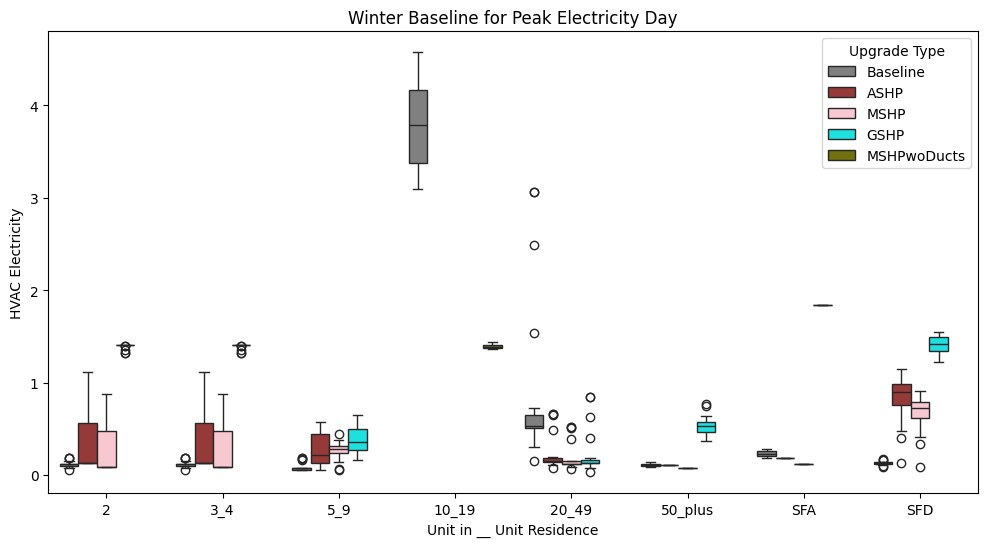

In [368]:
compare_residence_types_upgrades("boxplot", "time", "elec", "peak_electricity", selected_season=0, one_representative_day = False, hvac_only = True, break_out_hvac = False)

In [18]:
def create_double_line_plots(selected_day="peak_electricity"):
    # figs, axes = plt.subplots(1,len(building_unit_type_to_resstock_category))
    for i, (unit_type, resstock_category) in enumerate(building_unit_type_to_resstock_category.items()):
        # print(unit_type)
        fig, ax = plt.subplots(2,2)
        filepath = join(f"minneapolis_baseline_single_{unit_type}_unit_residence", 'run1','run', 'results_timeseries.csv')
        timeseries_data = pd.read_csv(filepath, low_memory=False, usecols=["Time", "Fuel Use: Electricity: Total", "Weather: Drybulb Temperature"])
        
        # Assuming 'Time' column is of datetime type, if not convert it
        timeseries_data['Time'] = pd.to_datetime(timeseries_data['Time'])

        # Define seasons
        def get_season(date):
            if date.month in [12, 1, 2]:
                return 'Winter'
            elif date.month in [3, 4, 5]:
                return 'Spring'
            elif date.month in [6, 7, 8]:
                return 'Summer'
            else:
                return 'Fall'

        # Create a 'Season' column
        timeseries_data['Season'] = timeseries_data['Time'].apply(get_season)

        # Extract just the date from 'Time'
        timeseries_data['Date'] = timeseries_data['Time'].dt.date

        # Group by 'Date' and 'Season' and calculate the mean temperature for each day
        daily_avg_temp = timeseries_data.groupby(['Date', 'Season'])['Weather: Drybulb Temperature'].mean().reset_index()
        daily_peak_electricity_use = timeseries_data.groupby(['Date', 'Season'])["Fuel Use: Electricity: Total"].max().reset_index()

        # Function to find the representative day for each season
        def find_representative_day(season):
            if selected_day == "median":
                season_data = daily_avg_temp[daily_avg_temp['Season'] == season]
                season_mean_temp = season_data['Weather: Drybulb Temperature'].mean()
                representative_day = season_data.iloc[(season_data['Weather: Drybulb Temperature'] - season_mean_temp).abs().argsort()].iloc[0]
                # print(representative_day['Date'])
                return representative_day['Date']
            if selected_day == "peak_electricity":
                season_data = daily_peak_electricity_use[daily_peak_electricity_use['Season'] == season]
                season_peak_electricity_use = season_data["Fuel Use: Electricity: Total"].max()
                representative_day = season_data[(season_data["Fuel Use: Electricity: Total"] == season_peak_electricity_use)].iloc[0]
                # print(representative_day['Date'])
                return representative_day['Date']

        # Find the representative day for each season
        representative_days = {season: find_representative_day(season) for season in seasons}

        # Filter the original dataframe for the 24-hour periods of the representative days
        representative_days_df = pd.DataFrame()
        for i, (season, representative_day) in enumerate(representative_days.items()):
            ax1 = ax[i//2][i%2]
            representative_day_data = timeseries_data[(timeseries_data['Date'] == representative_day)]
            ax1.scatter(x=representative_day_data[label_to_column["time"]], y=representative_day_data[label_to_column["elec"]], c="#D81B60", label=label_to_column["elec"])
            ax1.set_title(season)
            ax1.set_xlabel("Time of Day")
            ax1.set_ylabel("Electricity (kWh)", color="#D81B60")
            ax1.set_xticks([])
            ax2 = ax1.twinx()
            ax2.scatter(x=representative_day_data[label_to_column["time"]], y=representative_day_data[label_to_column["temp"]], c="#1E88E5", label=label_to_column["temp"])
            ax2.set_ylabel("Outdoor Temperature (F)", color="#1E88E5")
        # Shrink current axis by 20%
        # box = ax.get_position()
        # ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # Put a legend to the right of the current axis
        # ax.legend(loc='center left', bbox_to_anchor=(1, 0.8))
        fig.tight_layout()
        fig.suptitle(f"Unit in a {unit_type} unit building")
        plt.show()
        fig.savefig(join(f"minneapolis_baseline_single_{unit_type}_unit_residence", "double_line_plot.svg"), bbox_inches='tight')

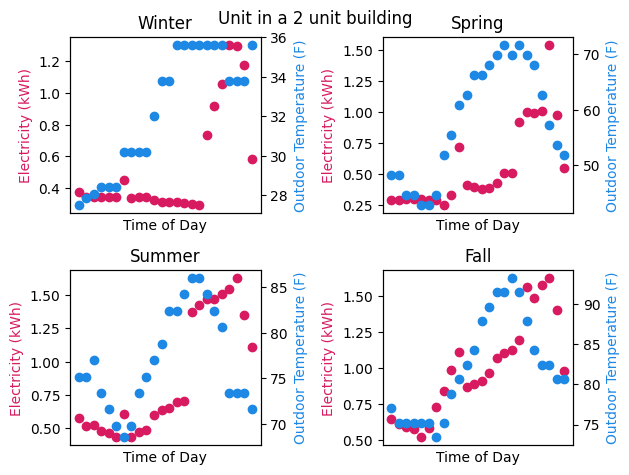

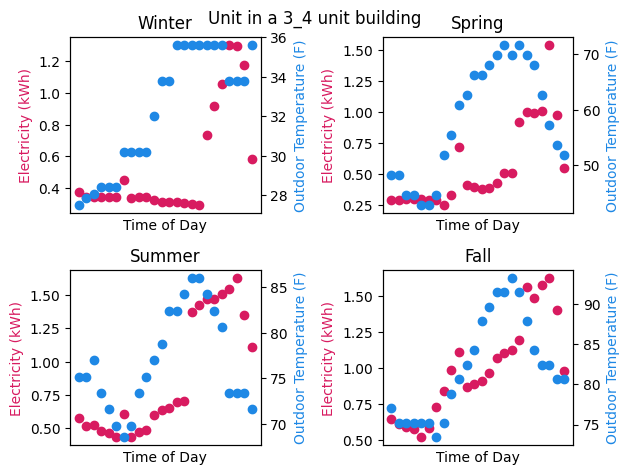

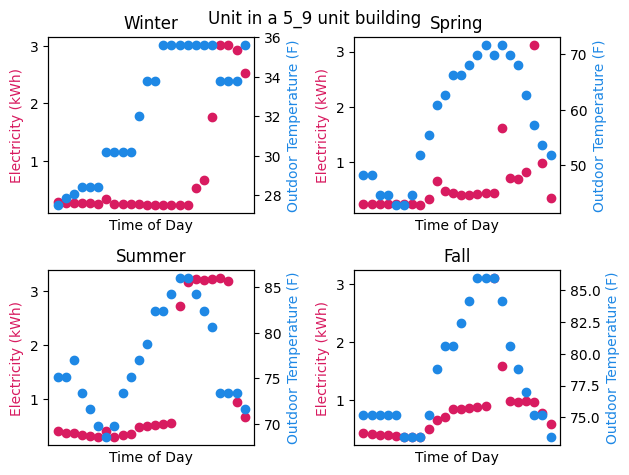

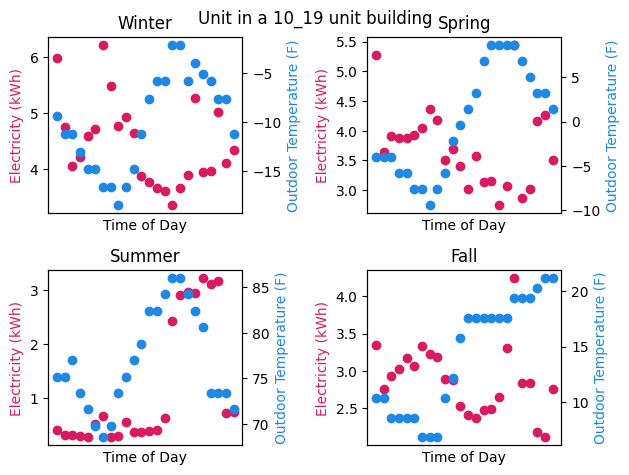

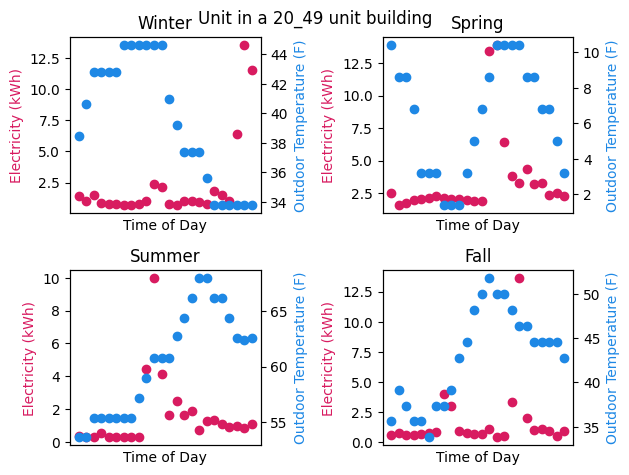

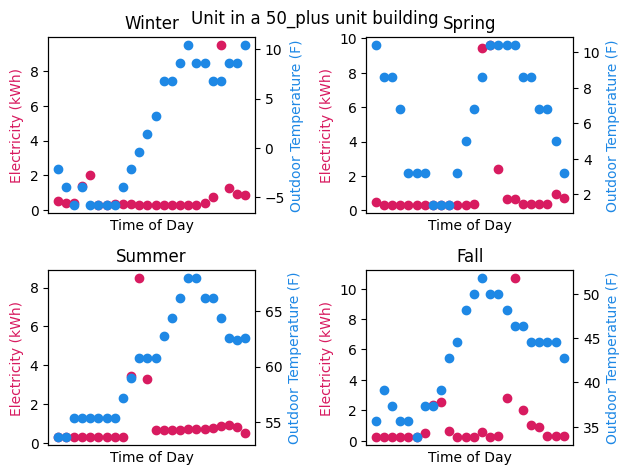

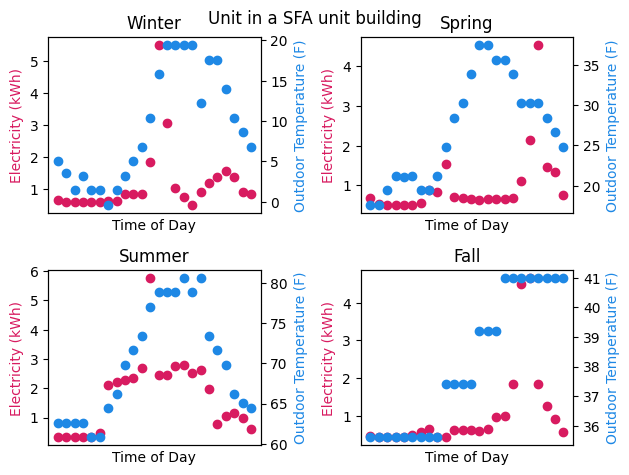

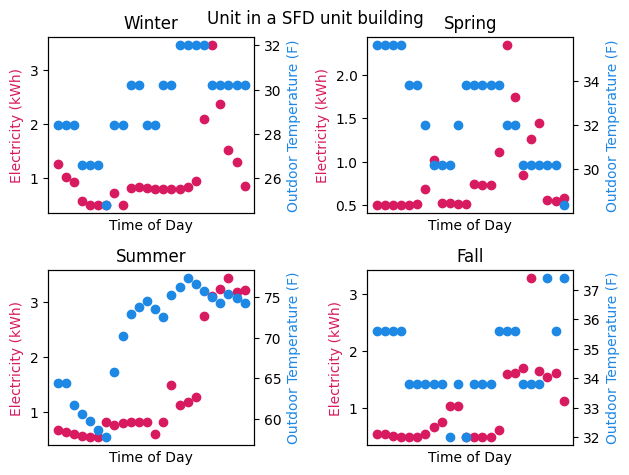

In [19]:
create_double_line_plots()

In [68]:
def create_stacked_bar_charts(selected_day="peak_electricity"):
    electricity_use_cols = ["End Use: Electricity: Heating",
            "End Use: Electricity: Heating Fans/Pumps",
            "End Use: Electricity: Heating Heat Pump Backup",
            "End Use: Electricity: Heating Heat Pump Backup Fans/Pumps",
            "End Use: Electricity: Cooling",
            "End Use: Electricity: Cooling Fans/Pumps",
            "End Use: Electricity: Lighting Interior",
            "End Use: Electricity: Lighting Exterior",
            "End Use: Electricity: Mech Vent",
            "End Use: Electricity: Refrigerator",
            "End Use: Electricity: Range/Oven",
            "End Use: Electricity: Ceiling Fan",
            "End Use: Electricity: Plug Loads"]
    useful_cols = electricity_use_cols + ["Fuel Use: Electricity: Total", "Time"]
    for i, (unit_type, resstock_category) in enumerate(building_unit_type_to_resstock_category.items()):
        fig, ax = plt.subplots(2,2)
        filepath = join(f"minneapolis_baseline_single_{unit_type}_unit_residence", 'run1','run', 'results_timeseries.csv')
        timeseries_data = pd.read_csv(filepath, low_memory=False, usecols=lambda x: x in useful_cols)
        # print(timeseries_data)
        
        # Assuming 'Time' column is of datetime type, if not convert it
        timeseries_data['Time'] = pd.to_datetime(timeseries_data['Time'])

        # Define seasons
        def get_season(date):
            if date.month in [12, 1, 2]:
                return 'Winter'
            elif date.month in [3, 4, 5]:
                return 'Spring'
            elif date.month in [6, 7, 8]:
                return 'Summer'
            else:
                return 'Fall'

        # Create a 'Season' column
        timeseries_data['Season'] = timeseries_data['Time'].apply(get_season)

        # Extract just the date from 'Time'
        timeseries_data['Date'] = timeseries_data['Time'].dt.date

        # Group by 'Date' and 'Season' and calculate the mean temperature for each day
        # daily_avg_temp = timeseries_data.groupby(['Date', 'Season'])['Weather: Drybulb Temperature'].mean().reset_index()
        daily_peak_electricity_use = timeseries_data.groupby(['Date', 'Season'])["Fuel Use: Electricity: Total"].max().reset_index()

        # Function to find the representative day for each season
        def find_representative_day(season):
            # if selected_day == "median":
            #     season_data = daily_avg_temp[daily_avg_temp['Season'] == season]
            #     season_mean_temp = season_data['Weather: Drybulb Temperature'].mean()
            #     representative_day = season_data.iloc[(season_data['Weather: Drybulb Temperature'] - season_mean_temp).abs().argsort()].iloc[0]
            #     return representative_day['Date']
            if selected_day == "peak_electricity":
                season_data = daily_peak_electricity_use[daily_peak_electricity_use['Season'] == season]
                season_peak_electricity_use = season_data["Fuel Use: Electricity: Total"].max()
                representative_day = season_data[(season_data["Fuel Use: Electricity: Total"] == season_peak_electricity_use)].iloc[0]
                return representative_day['Date']

        # Find the representative day for each season
        representative_days = {season: find_representative_day(season) for season in seasons}

        # Filter the original dataframe for the 24-hour periods of the representative days
        representative_days_df = pd.DataFrame()
        for i, (season, representative_day) in enumerate(representative_days.items()):
            ax1 = ax[i//2][i%2]
            # print(timeseries_data.columns)
            representative_day_data = timeseries_data[(timeseries_data['Date'] == representative_day)]
            representative_day_data.set_index("Time", inplace=True)
            representative_day_data.drop(["Season", "Date", 'Fuel Use: Electricity: Total'], axis=1, inplace=True)

            representative_day_data.rename(lambda x: x.replace("End Use: Electricity: ", ""), axis=1, inplace=True)

            # print(representative_day_data.columns)
            # representative_day_data[["Fuel Use: Natural Gas: Total"]].plot(ax=ax1, kind="bar", stacked=True, use_index=True, legend=False)
            # representative_day_data.drop(["Fuel Use: Natural Gas: Total"], axis=1, inplace=True)
            representative_day_data.plot(ax=ax1, kind="bar", stacked=True, use_index=True, legend=False)
            # ax1.scatter(x=representative_day_data[label_to_column["time"]], y=representative_day_data[label_to_column["elec"]], c="#D81B60", label=label_to_column["elec"])
            ax1.set_title(season)
            ax1.set_xlabel("Time of Day")
            ax1.set_ylabel("Electricity (kWh)")
            ax1.set_xticks([])
            # ax1.legend().hide()
        
        # Put a legend to the right of the current axis
        # legend_entries = [x.replace("End Use: Electricity: ", "") for x in electricity_use_cols]
        # handles, labels = fig.get_legend_handles_labels()
        # unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
        # legend_entries = *zip(*unique)
        ax[0][1].legend(loc='upper left', bbox_to_anchor=(1, 1), ncols=1)
        # fig.legend(legend_entries, loc='upper center', bbox_to_anchor=(0.5, 0), ncols=2)
        fig.suptitle(f"Unit in a {unit_type} unit building")
        fig.tight_layout()
        plt.show()
        fig.savefig(join(f"minneapolis_baseline_single_{unit_type}_unit_residence", "stacked_bar_chart.svg"), bbox_inches='tight')

C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\3786889299.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  representative_day_data.drop(["Season", "Date", 'Fuel Use: Electricity: Total'], axis=1, inplace=True)
C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\3786889299.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  representative_day_data.rename(lambda x: x.replace("End Use: Electricity: ", ""), axis=1, inplace=True)
C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\3786889299.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

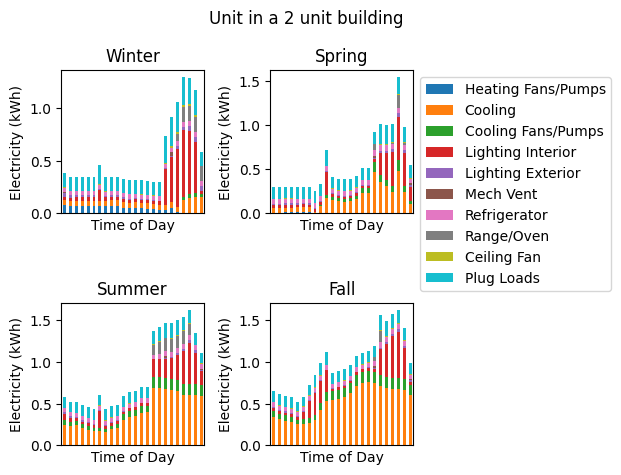

C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\3786889299.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  representative_day_data.drop(["Season", "Date", 'Fuel Use: Electricity: Total'], axis=1, inplace=True)
C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\3786889299.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  representative_day_data.rename(lambda x: x.replace("End Use: Electricity: ", ""), axis=1, inplace=True)
C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\3786889299.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

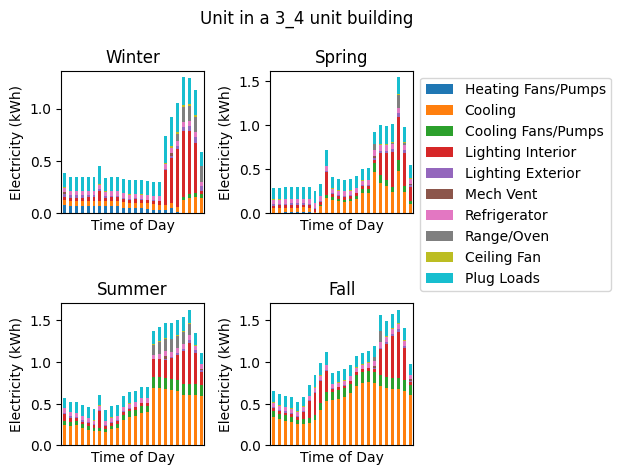

C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\3786889299.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  representative_day_data.drop(["Season", "Date", 'Fuel Use: Electricity: Total'], axis=1, inplace=True)
C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\3786889299.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  representative_day_data.rename(lambda x: x.replace("End Use: Electricity: ", ""), axis=1, inplace=True)
C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\3786889299.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

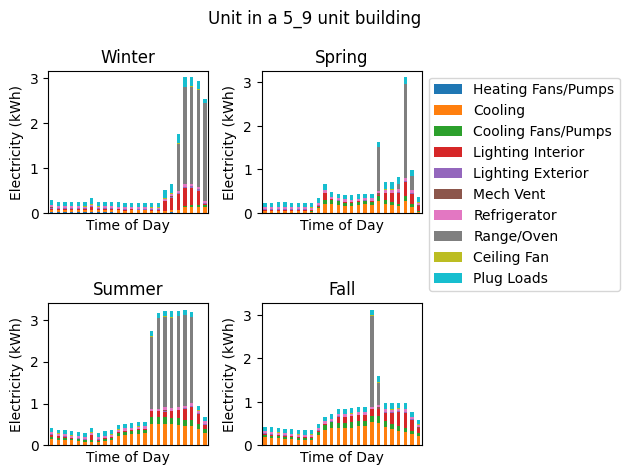

C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\3786889299.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  representative_day_data.drop(["Season", "Date", 'Fuel Use: Electricity: Total'], axis=1, inplace=True)
C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\3786889299.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  representative_day_data.rename(lambda x: x.replace("End Use: Electricity: ", ""), axis=1, inplace=True)
C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\3786889299.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

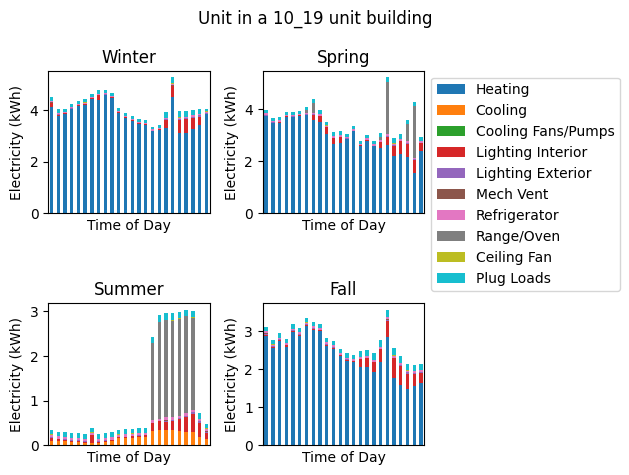

C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\3786889299.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  representative_day_data.drop(["Season", "Date", 'Fuel Use: Electricity: Total'], axis=1, inplace=True)
C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\3786889299.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  representative_day_data.rename(lambda x: x.replace("End Use: Electricity: ", ""), axis=1, inplace=True)
C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\3786889299.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

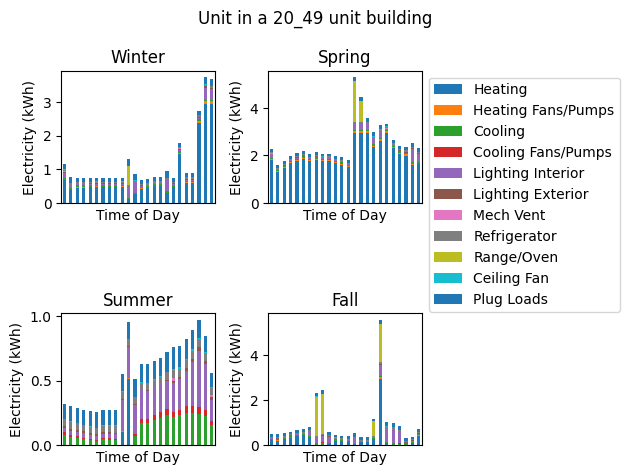

C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\3786889299.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  representative_day_data.drop(["Season", "Date", 'Fuel Use: Electricity: Total'], axis=1, inplace=True)
C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\3786889299.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  representative_day_data.rename(lambda x: x.replace("End Use: Electricity: ", ""), axis=1, inplace=True)
C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\3786889299.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

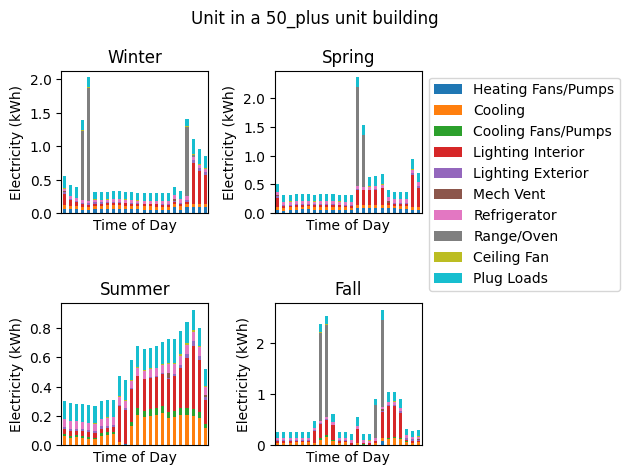

C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\3786889299.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  representative_day_data.drop(["Season", "Date", 'Fuel Use: Electricity: Total'], axis=1, inplace=True)
C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\3786889299.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  representative_day_data.rename(lambda x: x.replace("End Use: Electricity: ", ""), axis=1, inplace=True)
C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\3786889299.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

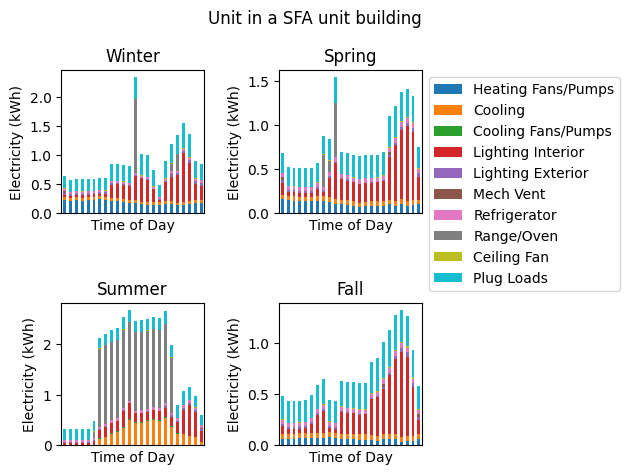

C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\3786889299.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  representative_day_data.drop(["Season", "Date", 'Fuel Use: Electricity: Total'], axis=1, inplace=True)
C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\3786889299.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  representative_day_data.rename(lambda x: x.replace("End Use: Electricity: ", ""), axis=1, inplace=True)
C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\3786889299.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

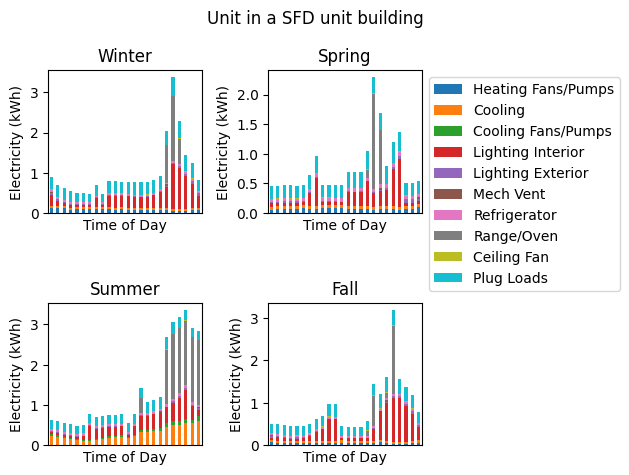

In [69]:
create_stacked_bar_charts()

In [76]:
def create_nat_gas_bar_charts(selected_day="peak_electricity"):
    nat_gas_use_cols = ["End Use: Natural Gas: Heating","End Use: Natural Gas: Hot Water","End Use: Natural Gas: Range/Oven"]
    useful_cols = nat_gas_use_cols + ["Fuel Use: Electricity: Total", "Time"]
    for i, (unit_type, resstock_category) in enumerate(building_unit_type_to_resstock_category.items()):
        try:
            fig, ax = plt.subplots(2,2)
            filepath = join(f"minneapolis_baseline_single_{unit_type}_unit_residence", 'run1','run', 'results_timeseries.csv')
            timeseries_data = pd.read_csv(filepath, low_memory=False, usecols=lambda x: x in useful_cols)
            # print(timeseries_data)
            
            # Assuming 'Time' column is of datetime type, if not convert it
            timeseries_data['Time'] = pd.to_datetime(timeseries_data['Time'])

            # Define seasons
            def get_season(date):
                if date.month in [12, 1, 2]:
                    return 'Winter'
                elif date.month in [3, 4, 5]:
                    return 'Spring'
                elif date.month in [6, 7, 8]:
                    return 'Summer'
                else:
                    return 'Fall'

            # Create a 'Season' column
            timeseries_data['Season'] = timeseries_data['Time'].apply(get_season)

            # Extract just the date from 'Time'
            timeseries_data['Date'] = timeseries_data['Time'].dt.date

            # Group by 'Date' and 'Season' and calculate the mean temperature for each day
            # daily_avg_temp = timeseries_data.groupby(['Date', 'Season'])['Weather: Drybulb Temperature'].mean().reset_index()
            daily_peak_electricity_use = timeseries_data.groupby(['Date', 'Season'])["Fuel Use: Electricity: Total"].max().reset_index()

            # Function to find the representative day for each season
            def find_representative_day(season):
                # if selected_day == "median":
                #     season_data = daily_avg_temp[daily_avg_temp['Season'] == season]
                #     season_mean_temp = season_data['Weather: Drybulb Temperature'].mean()
                #     representative_day = season_data.iloc[(season_data['Weather: Drybulb Temperature'] - season_mean_temp).abs().argsort()].iloc[0]
                #     return representative_day['Date']
                if selected_day == "peak_electricity":
                    season_data = daily_peak_electricity_use[daily_peak_electricity_use['Season'] == season]
                    season_peak_electricity_use = season_data["Fuel Use: Electricity: Total"].max()
                    representative_day = season_data[(season_data["Fuel Use: Electricity: Total"] == season_peak_electricity_use)].iloc[0]
                    return representative_day['Date']

            # Find the representative day for each season
            representative_days = {season: find_representative_day(season) for season in seasons}

            # Filter the original dataframe for the 24-hour periods of the representative days
            representative_days_df = pd.DataFrame()
            for i, (season, representative_day) in enumerate(representative_days.items()):
                ax1 = ax[i//2][i%2]
                # print(timeseries_data.columns)
                representative_day_data = timeseries_data[(timeseries_data['Date'] == representative_day)]
                representative_day_data.set_index("Time", inplace=True)
                representative_day_data.drop(["Season", "Date", 'Fuel Use: Electricity: Total'], axis=1, inplace=True)

                # representative_day_data.rename(lambda x: x.replace("End Use: Electricity: ", ""), axis=1, inplace=True)

                # print(representative_day_data.columns)
                # representative_day_data[["Fuel Use: Natural Gas: Total"]].plot(ax=ax1, kind="bar", stacked=True, use_index=True, legend=False)
                # representative_day_data.drop(["Fuel Use: Natural Gas: Total"], axis=1, inplace=True)
                representative_day_data.plot(ax=ax1, kind="bar", stacked=True, use_index=True, legend=False)
                # ax1.scatter(x=representative_day_data[label_to_column["time"]], y=representative_day_data[label_to_column["elec"]], c="#D81B60", label=label_to_column["elec"])
                ax1.set_title(season)
                ax1.set_xlabel("Time of Day")
                ax1.set_ylabel("Natural Gas Usage (kWh)")
                ax1.set_xticks([])
                # ax1.legend().hide()
            
            # Put a legend to the right of the current axis
            legend_entries = [x.replace("End Use: Natural Gas: ", "") for x in nat_gas_use_cols if x in representative_day_data.columns]
            # handles, labels = fig.get_legend_handles_labels()
            # unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
            # legend_entries = *zip(*unique)
            # ax[1][0].legend(loc='upper left', bbox_to_anchor=(0, 0), ncols=1)
            fig.legend(legend_entries, loc='upper center', bbox_to_anchor=(0.5, 0), ncols=3)
            fig.suptitle(f"Unit in a {unit_type} unit building")
            fig.tight_layout()
            plt.show()
            fig.savefig(join(f"minneapolis_baseline_single_{unit_type}_unit_residence", "natural_gas_stacked_bar_chart.svg"), bbox_inches='tight')
        except Exception as e:
            pass

C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\2534507394.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  representative_day_data.drop(["Season", "Date", 'Fuel Use: Electricity: Total'], axis=1, inplace=True)
C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\2534507394.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  representative_day_data.drop(["Season", "Date", 'Fuel Use: Electricity: Total'], axis=1, inplace=True)
C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\2534507394.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documenta

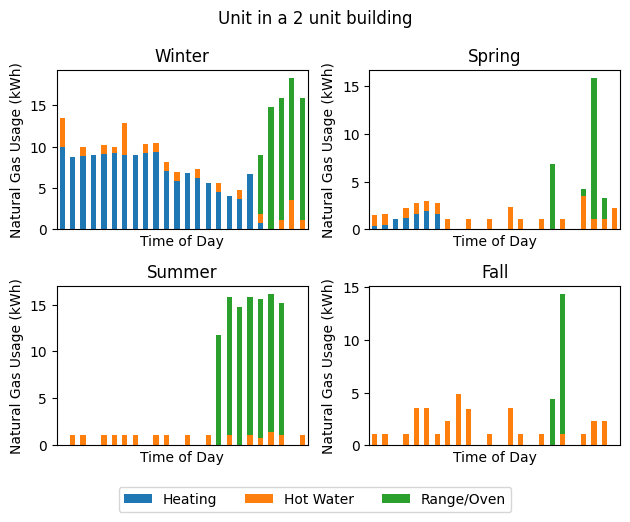

C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\2534507394.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  representative_day_data.drop(["Season", "Date", 'Fuel Use: Electricity: Total'], axis=1, inplace=True)
C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\2534507394.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  representative_day_data.drop(["Season", "Date", 'Fuel Use: Electricity: Total'], axis=1, inplace=True)
C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\2534507394.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documenta

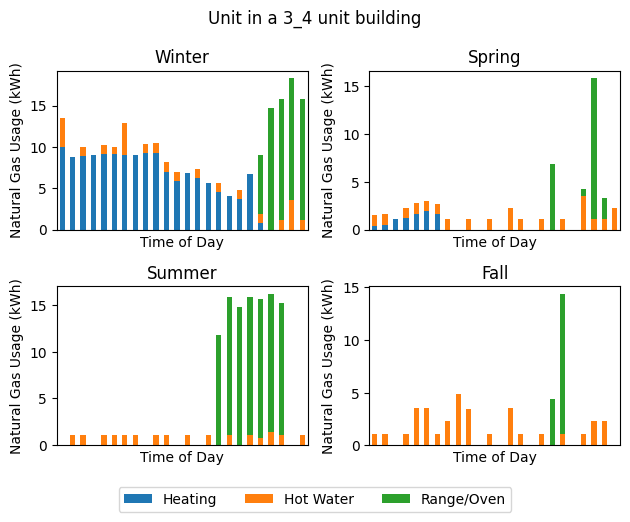

C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\2534507394.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  representative_day_data.drop(["Season", "Date", 'Fuel Use: Electricity: Total'], axis=1, inplace=True)
C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\2534507394.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  representative_day_data.drop(["Season", "Date", 'Fuel Use: Electricity: Total'], axis=1, inplace=True)
C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\2534507394.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documenta

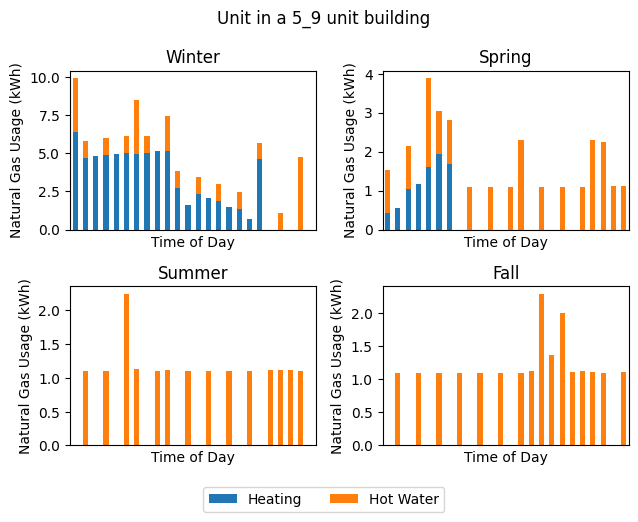

C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\2534507394.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  representative_day_data.drop(["Season", "Date", 'Fuel Use: Electricity: Total'], axis=1, inplace=True)
C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\2534507394.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  representative_day_data.drop(["Season", "Date", 'Fuel Use: Electricity: Total'], axis=1, inplace=True)
C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\2534507394.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documenta

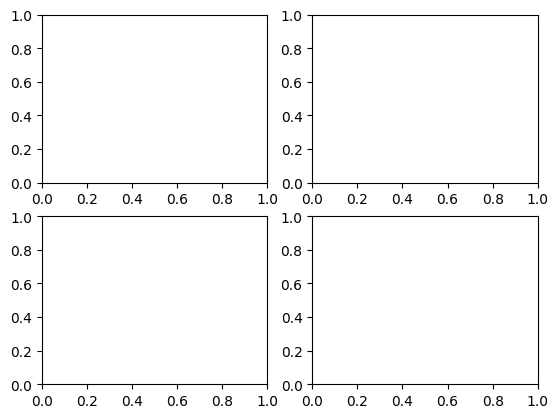

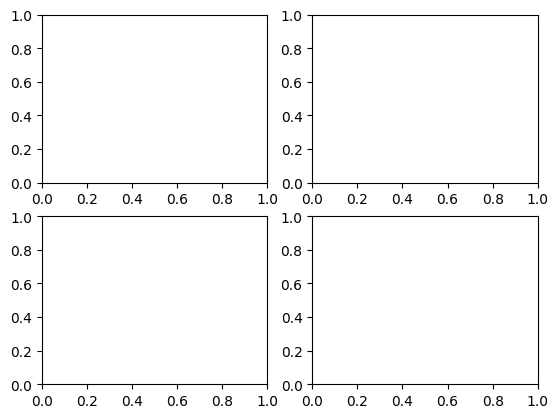

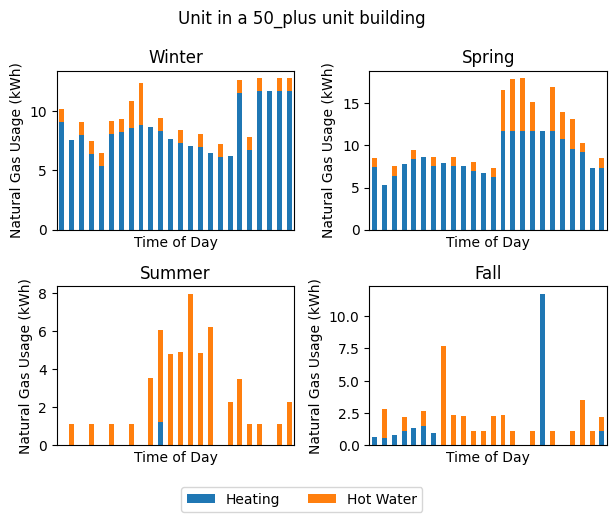

C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\2534507394.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  representative_day_data.drop(["Season", "Date", 'Fuel Use: Electricity: Total'], axis=1, inplace=True)
C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\2534507394.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  representative_day_data.drop(["Season", "Date", 'Fuel Use: Electricity: Total'], axis=1, inplace=True)
C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\2534507394.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documenta

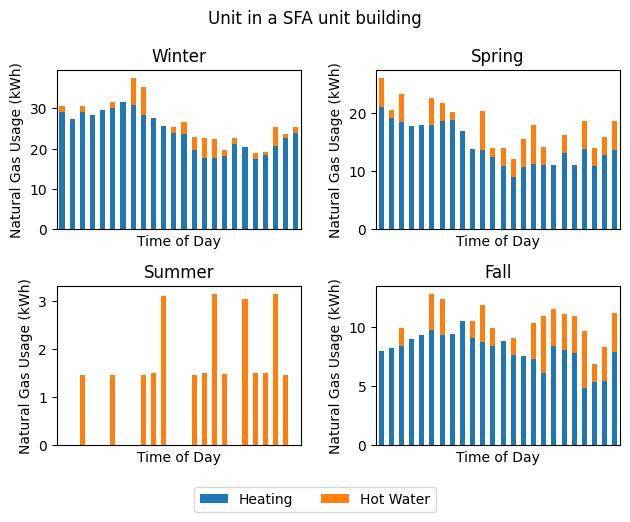

C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\2534507394.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  representative_day_data.drop(["Season", "Date", 'Fuel Use: Electricity: Total'], axis=1, inplace=True)
C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\2534507394.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  representative_day_data.drop(["Season", "Date", 'Fuel Use: Electricity: Total'], axis=1, inplace=True)
C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\2534507394.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documenta

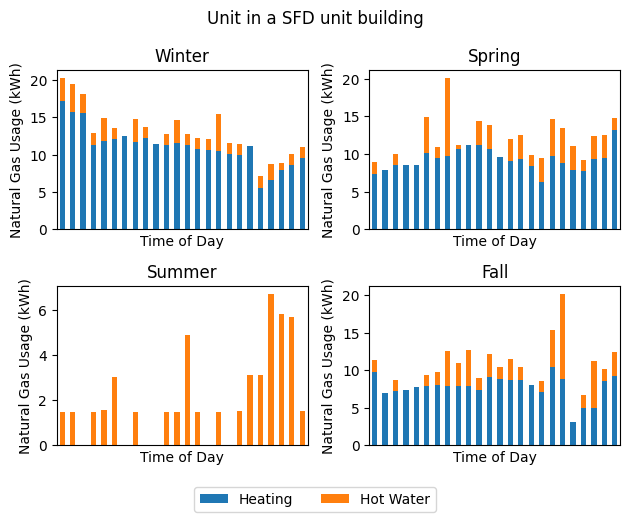

In [77]:
create_nat_gas_bar_charts()

In [80]:
def print_peak_electricity_days():

    for i, (unit_type, resstock_category) in enumerate(building_unit_type_to_resstock_category.items()):
        # print(unit_type)
        filepath = join(f"minneapolis_baseline_single_{unit_type}_unit_residence", 'run1','run', 'results_timeseries.csv')
        timeseries_data = pd.read_csv(filepath, low_memory=False, usecols=["Time", "Fuel Use: Electricity: Total", "Weather: Drybulb Temperature"])
        
        # Assuming 'Time' column is of datetime type, if not convert it
        timeseries_data['Time'] = pd.to_datetime(timeseries_data['Time'])

        # Define seasons
        def get_season(date):
            if date.month in [12, 1, 2]:
                return 'Winter'
            elif date.month in [3, 4, 5]:
                return 'Spring'
            elif date.month in [6, 7, 8]:
                return 'Summer'
            else:
                return 'Fall'

        # Create a 'Season' column
        timeseries_data['Season'] = timeseries_data['Time'].apply(get_season)

        # Extract just the date from 'Time'
        timeseries_data['Date'] = timeseries_data['Time'].dt.date

        # Group by 'Date' and 'Season' and calculate the mean temperature for each day
        daily_avg_temp = timeseries_data.groupby(['Date', 'Season'])['Weather: Drybulb Temperature'].mean().reset_index()
        daily_peak_electricity_use = timeseries_data.groupby(['Date', 'Season'])["Fuel Use: Electricity: Total"].max().reset_index()

        # Function to find the representative day for each season
        def find_representative_day(season):
            season_data = daily_peak_electricity_use[daily_peak_electricity_use['Season'] == season]
            season_peak_electricity_use = season_data["Fuel Use: Electricity: Total"].max()
            representative_day = season_data[(season_data["Fuel Use: Electricity: Total"] == season_peak_electricity_use)].iloc[0]
            # print(representative_day['Date'])
            return representative_day['Date']

        # Find the representative day for each season
        print(f"For a {unit_type}, the representative days are: ")
        for season in seasons:
            print(f"{find_representative_day(season)} for {season}")

In [81]:
print_peak_electricity_days()

For a 2, the representative days are: 
2007-02-01 for Winter
2007-05-15 for Spring
2007-08-13 for Summer
2007-09-07 for Fall
For a 3_4, the representative days are: 
2007-02-01 for Winter
2007-05-15 for Spring
2007-08-13 for Summer
2007-09-07 for Fall
For a 5_9, the representative days are: 
2007-02-01 for Winter
2007-05-15 for Spring
2007-08-13 for Summer
2007-09-09 for Fall
For a 10_19, the representative days are: 
2007-01-09 for Winter
2007-03-09 for Spring
2007-08-13 for Summer
2007-11-17 for Fall
For a 20_49, the representative days are: 
2007-12-16 for Winter
2007-03-04 for Spring
2007-06-10 for Summer
2007-11-05 for Fall
For a 50_plus, the representative days are: 
2007-02-12 for Winter
2007-03-04 for Spring
2007-06-10 for Summer
2007-11-05 for Fall
For a SFA, the representative days are: 
2007-12-08 for Winter
2007-03-11 for Spring
2007-06-16 for Summer
2007-10-28 for Fall
For a SFD, the representative days are: 
2007-12-13 for Winter
2007-04-03 for Spring
2007-07-31 for Summe

In [136]:
def create_double_bar_charts_resstock_and_field_data(break_out_hvac=False):
    hvac_electricity_use_cols = ["End Use: Electricity: Heating",
        "End Use: Electricity: Heating Fans/Pumps",
        "End Use: Electricity: Heating Heat Pump Backup",
        "End Use: Electricity: Heating Heat Pump Backup Fans/Pumps",
        "End Use: Electricity: Cooling",
        "End Use: Electricity: Cooling Fans/Pumps"]
    # useful_cols = hvac_electricity_use_cols + ["Fuel Use: Electricity: Total", "Time"]
    # figs, axes = plt.subplots(1,len(building_unit_type_to_resstock_category))
    for i, (unit_type, resstock_category) in enumerate(building_unit_type_to_resstock_category.items()):
        # print(unit_type)
        fig, ax = plt.subplots()
        representative_days = None
        plot_data = []
        for j in range(5):
            if j == 0:
                continue
            try:
                desired_cols = ["Fuel Use: Electricity: Total", "Time"]
                filepath = join(f"minneapolis_upgrades_single_{unit_type}_unit_residence", f'run{j+1}','run', 'results_timeseries.csv')
                timeseries_data = pd.read_csv(filepath, low_memory=False)
                available_heating_cols = [col for col in desired_heating_cols if col in timeseries_data.columns]
                if len(available_heating_cols) == 0:
                    print("No heating data available")
                available_cooling_cols = [col for col in desired_cooling_cols if col in timeseries_data.columns]
                if len(available_heating_cols) == 0:
                    print("No cooling data available")
                available_hvac_cols = available_heating_cols + available_cooling_cols
                desired_cols += available_hvac_cols
                timeseries_data = timeseries_data[desired_cols]
                # timeseries_data = timeseries_data[desired_cols]
                if break_out_hvac:
                    timeseries_data["Heating Electricity"] = 0
                    for col in available_heating_cols:
                        if col in timeseries_data.columns:
                            timeseries_data["Heating Electricity"] += timeseries_data[col]
                    timeseries_data["Cooling Electricity"] = 0
                    for col in available_cooling_cols:
                        if col in timeseries_data.columns:
                            timeseries_data["Cooling Electricity"] += timeseries_data[col]
                else:
                    timeseries_data["HVAC Electricity"] = 0
                    for col in available_hvac_cols:
                        if col in timeseries_data.columns:
                            timeseries_data["HVAC Electricity"] += timeseries_data[col]

                # Assuming 'Time' column is of datetime type, if not convert it
                timeseries_data['Time'] = pd.to_datetime(timeseries_data['Time'])

                # Define seasons
                def get_season(date):
                    if date.month in [12, 1, 2]:
                        return 'Winter'
                    elif date.month in [3, 4, 5]:
                        return 'Spring'
                    elif date.month in [6, 7, 8]:
                        return 'Summer'
                    else:
                        return 'Fall'

                # Create a 'Season' column
                timeseries_data['Season'] = timeseries_data['Time'].apply(get_season)

                # Extract just the date from 'Time'
                timeseries_data['Date'] = timeseries_data['Time'].dt.date

                if representative_days is None:
                    # Group by 'Date' and 'Season' and calculate the mean temperature for each day
                    daily_peak_electricity_use = timeseries_data.groupby(['Date', 'Season'])["Fuel Use: Electricity: Total"].max().reset_index()

                    # Function to find the representative day for each season
                    def find_representative_day(season):
                        season_data = daily_peak_electricity_use[daily_peak_electricity_use['Season'] == season]
                        season_peak_electricity_use = season_data["Fuel Use: Electricity: Total"].max()
                        representative_day = season_data[(season_data["Fuel Use: Electricity: Total"] == season_peak_electricity_use)].iloc[0]
                        # print(representative_day['Date'])
                        return representative_day['Date']

                    # Find the representative day for each season
                    representative_days = {season: find_representative_day(season) for season in seasons}

                # Filter the original dataframe for the 24-hour periods of the representative days
                # for i, (season, representative_day) in enumerate(representative_days.items()):
                for i, season_name in enumerate(["Summer"]): # ,"winter"
                    representative_day = representative_days[season_name]
                    ax1 = ax#[i]
                    representative_day_data = timeseries_data[(timeseries_data['Date'] == representative_day)]
                    representative_day_data.set_index("Time", inplace=True)
                    representative_day_data.drop(["Season", "Date", 'Fuel Use: Electricity: Total'], axis=1, inplace=True)
                    y_column_list = ["Heating Electricity", "Cooling Electricity"] if break_out_hvac else ["HVAC Electricity"]
                    representative_day_data[upgrade_to_label[j]] = representative_day_data[y_column_list]
                    plot_data.append(representative_day_data[upgrade_to_label[j]])
                    # representative_day_data[upgrade_to_label[j]].plot(ax=ax1, kind="bar", stacked=False, use_index=True)
                    # ax1.set_title(season_name.title())
                    # ax1.set_xlabel("Time of Day")
                    # ax1.set_ylabel("Electricity (kWh)")
                    # ax1.set_xticks([])
                    
            except Exception as e:
                continue

        for i, season_name in enumerate(["Summer"]):
            filepath = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), f'ohio_{season_name}_data.csv')
            field_data = pd.read_csv(filepath)
            field_data['Time'] = pd.to_datetime(field_data['Time'])
            field_data['Date'] = field_data['Time'].dt.date
            # print(field_data)
            # print(representative_days[season_name])
            field_data = field_data[(field_data['Date'] == representative_days[season_name])]
            # print(field_data)
            field_data.drop(["Date"], axis=1, inplace=True)
            field_data.set_index("Time", inplace=True)
            # print(field_data)
            ax1 = ax
            plot_data.append(field_data)
            # field_data.plot(ax=ax1, kind="bar", stacked=False, use_index=True, label="Field Data")
            # ax1.set_xticks([])

        pd.concat(plot_data, axis=1).plot.bar(ax=ax, color=upgrade_to_color_dict)
        ax.set_ylabel("Electricity use (kWh)")
        ax.set_xlabel("Hour")
        # ax.set_xticks(range(1,25))
        ax.set_xticklabels(range(1,25))

        # Put a legend to the right of the current axis
        # ax.legend(loc='center left', bbox_to_anchor=(1, 0.8))
        fig.suptitle(f"Unit in a {unit_type} unit building")
        fig.tight_layout()
        # fig.legend()
        plt.show()
        fig.savefig(join(f"minneapolis_baseline_single_{unit_type}_unit_residence", "resstock_vs_trane_comparison_bar_chart.svg"), bbox_inches='tight')

C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\1798643725.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  representative_day_data.drop(["Season", "Date", 'Fuel Use: Electricity: Total'], axis=1, inplace=True)
C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\1798643725.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  representative_day_data[upgrade_to_label[j]] = representative_day_data[y_column_list]
C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\1798643725.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

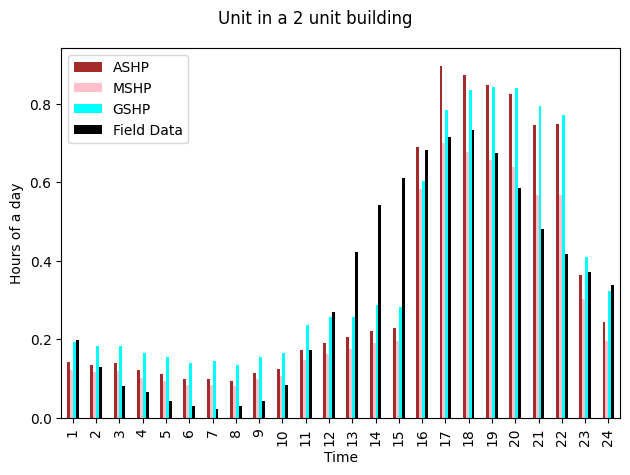

C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\1798643725.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  representative_day_data.drop(["Season", "Date", 'Fuel Use: Electricity: Total'], axis=1, inplace=True)
C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\1798643725.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  representative_day_data[upgrade_to_label[j]] = representative_day_data[y_column_list]
C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\1798643725.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

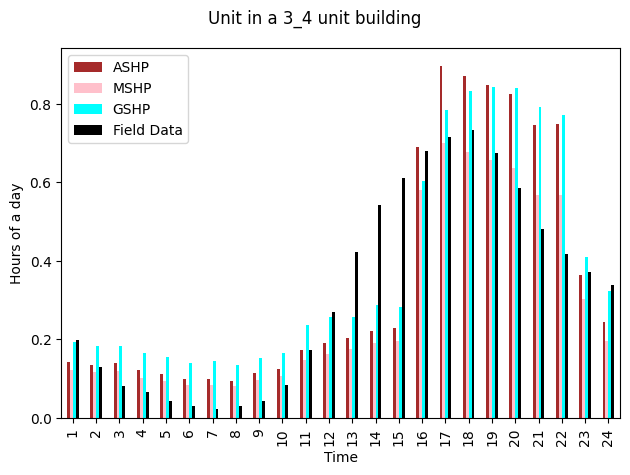

C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\1798643725.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  representative_day_data.drop(["Season", "Date", 'Fuel Use: Electricity: Total'], axis=1, inplace=True)
C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\1798643725.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  representative_day_data[upgrade_to_label[j]] = representative_day_data[y_column_list]
C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\1798643725.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

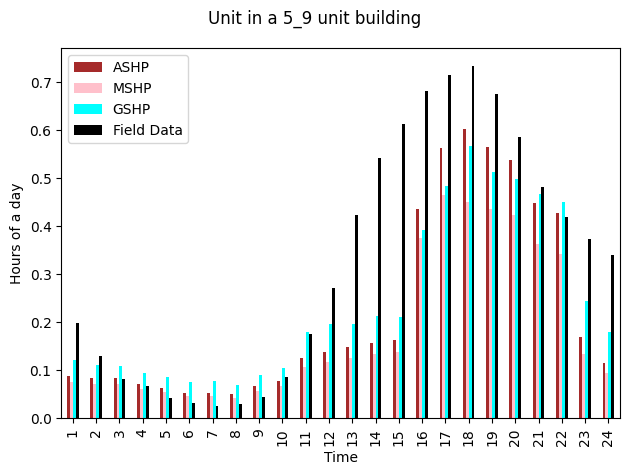

C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\1798643725.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  representative_day_data.drop(["Season", "Date", 'Fuel Use: Electricity: Total'], axis=1, inplace=True)
C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\1798643725.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  representative_day_data[upgrade_to_label[j]] = representative_day_data[y_column_list]


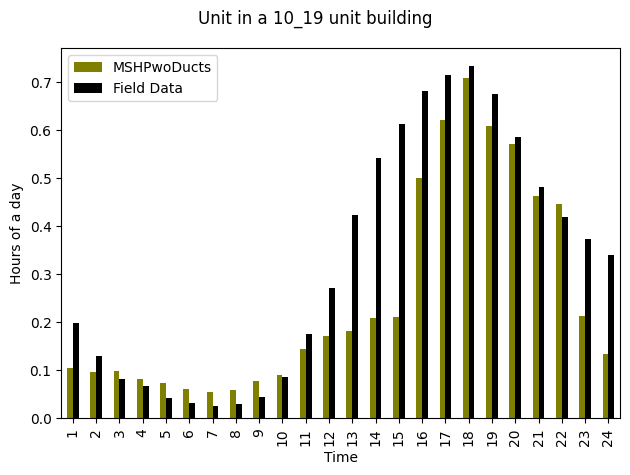

C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\1798643725.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  representative_day_data.drop(["Season", "Date", 'Fuel Use: Electricity: Total'], axis=1, inplace=True)
C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\1798643725.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  representative_day_data[upgrade_to_label[j]] = representative_day_data[y_column_list]
C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\1798643725.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

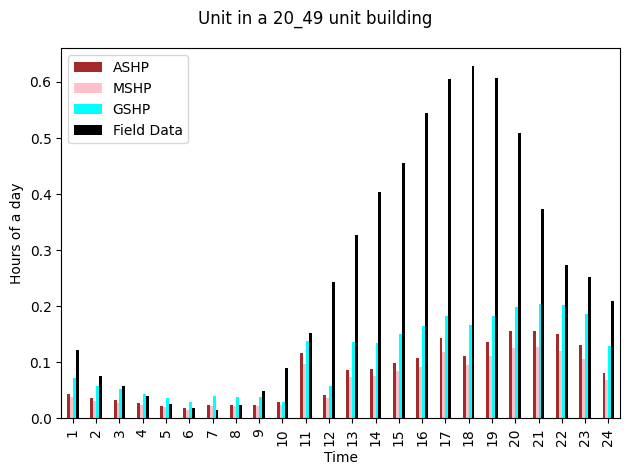

C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\1798643725.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  representative_day_data.drop(["Season", "Date", 'Fuel Use: Electricity: Total'], axis=1, inplace=True)
C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\1798643725.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  representative_day_data[upgrade_to_label[j]] = representative_day_data[y_column_list]
C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\1798643725.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

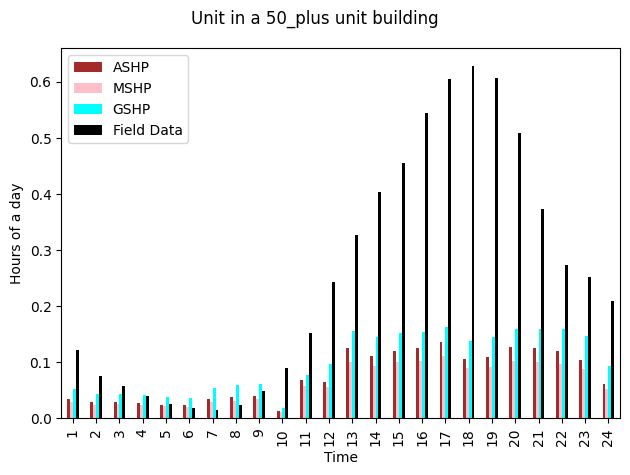

C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\1798643725.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  representative_day_data.drop(["Season", "Date", 'Fuel Use: Electricity: Total'], axis=1, inplace=True)
C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\1798643725.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  representative_day_data[upgrade_to_label[j]] = representative_day_data[y_column_list]
C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\1798643725.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

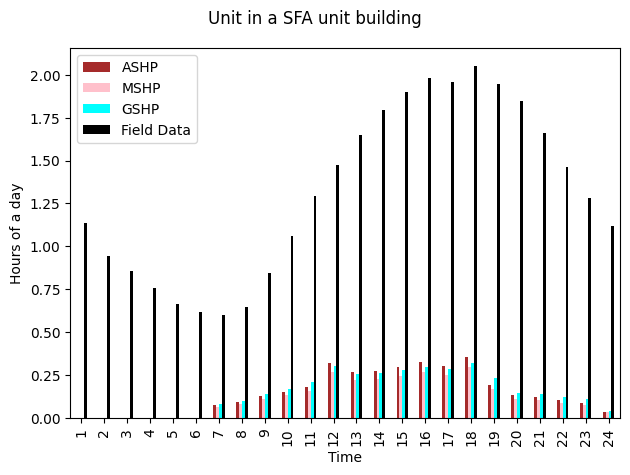

C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\1798643725.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  representative_day_data.drop(["Season", "Date", 'Fuel Use: Electricity: Total'], axis=1, inplace=True)
C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\1798643725.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  representative_day_data[upgrade_to_label[j]] = representative_day_data[y_column_list]
C:\Users\Arnav\AppData\Local\Temp\ipykernel_35148\1798643725.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

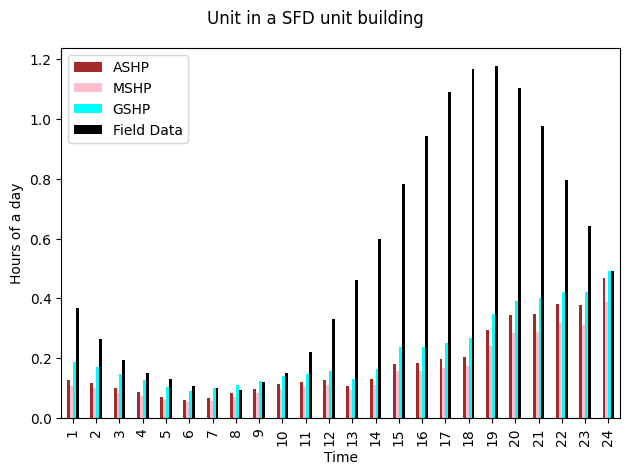

In [137]:
create_double_bar_charts_resstock_and_field_data()